In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from matplotlib.ticker import FuncFormatter

from sklearn.linear_model import Ridge

from statsmodels.stats.outliers_influence import variance_inflation_factor


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Load data

In [2]:
input_path_G = '/Users/ivyyang/Dropbox/cloud/Research/Research 2023/GQ/GQ_PSID/Data/G_data_2005.csv'
G0_data= pd.read_csv(input_path_G)
input_path_GQ = '/Users/ivyyang/Dropbox/cloud/Research/Research 2023/GQ/GQ_PSID/Data/GQ_data.csv'
GQ0_data = pd.read_csv(input_path_GQ)


In [4]:
G0_data.head()

,Unnamed: 0,pid,year,D_bus_fam_experience,D_stock,stock_value,D_college,D_2house,D_gender,D_black,...,inherit,labor_income,L_s,L_y,r_f,CCA1,CCA2,pi,Wealth_q_2009,Wealth_q_2005
0,1,2576170,2005,0,0,0.0,1,0,0,0,...,0.0,0.0,1632.164567,14565.098851,NaN,1.054771,-0.540911,0.0,2.0,2
1,2,2574001,2005,0,0,0.0,0,1,0,0,...,0.0,0.0,1632.164567,14565.098851,3.936667,1.054771,-0.540911,0.0,2.0,1
2,3,2201001,2005,0,0,0.0,0,0,0,0,...,0.0,0.0,1632.164567,14565.098851,3.936667,1.054771,-0.540911,0.0,1.0,2
3,4,1970003,2005,0,0,0.0,0,0,0,0,...,0.0,0.0,1632.164567,14565.098851,3.936667,1.054771,-0.540911,0.0,2.0,5
4,5,442003,2005,0,0,0.0,1,0,0,0,...,0.0,0.0,1632.164567,14565.098851,3.936667,1.054771,-0.540911,0.0,1.0,1


In [3]:
G0_data.rename(columns = {'education':'D_educ','age':'D_age'}, inplace=True)

#only keep a subset of G_data
columns_to_keep = ['pid', 'year', 'pi', 'wealth', 'fam_income', 'inherit', 'L_s', 'L_y', 'r_f','CCA1', 'CCA2', 'Wealth_q_2009'] + [col for col in G0_data.columns if col.startswith('D_')]

# Subset the dataset
G0_data = G0_data[columns_to_keep]

# Rename columns in G_data
G0_data.rename(columns= {'year':'time','pid': 'id', 'wealth': 'w', 'fam_income': 'y', 'inherit':'e'}, inplace=True)

# Create lags of the key choice variable (pi) from GQ_data using 'id' as the ID column
G0_data['pi_lag'] = G0_data.groupby('id')['pi'].shift(1)

# Ensure data is sorted by id and time
G0_data = G0_data.sort_values(by=['id', 'time'])

# Group by id and calculate the lagged L_s for each household
G0_data['L_s_lag'] = G0_data.groupby('id')['L_s'].shift(1)

# Calculate the growth rate r_s as the year-over-year change in L_s
G0_data['r_s'] = (G0_data['L_s'] / G0_data['L_s_lag']) - 1


In [4]:
print("PSID G_data")
G0_data.head()

PSID G_data


,id,time,pi,w,y,e,L_s,L_y,r_f,CCA1,...,D_married,D_own_or_rent,D_bond_ann,D_balanced_invest,D_OwnSelfBus,D_educ,D_age,pi_lag,L_s_lag,r_s
973,5003,2005,0.135135,74000.0,44000.0,0.0,1632.164567,14565.098851,3.936667,1.054771,...,1,1,0,0,0,12,42,NaN,NaN,NaN
2432,5003,2007,0.000000,82000.0,34600.0,0.0,1642.087354,14320.492063,2.859167,0.502665,...,1,1,0,0,0,12,45,0.135135,1632.164567,0.006080
4131,5003,2009,0.000000,133000.0,43000.0,0.0,1240.366278,13354.348816,0.143333,-0.888621,...,1,1,0,0,0,12,46,0.000000,1642.087354,-0.244641
5347,5003,2011,0.000000,125700.0,84300.0,0.0,1499.006582,13596.452016,0.069167,-0.926703,...,1,1,0,0,0,12,49,0.000000,1240.366278,0.208519
6685,5003,2013,0.000000,178000.0,77513.0,0.0,1957.127994,13563.297443,0.045417,-0.939021,...,1,1,0,0,0,12,51,0.000000,1499.006582,0.305617


In [5]:
print("PSID GQ_data")
GQ0_data.head()

PSID GQ_data


,Unnamed: 0,pid,time,pi,D_bus_fam_experience,D_stock,D_college,D_2house,D_gender,D_black,...,pi_PSID,e_PSID,L_y,L_s,r_f,CCA1,CCA2,date,wealth_q,Q_0
0,1,5003,0,0.0,0,1,0,1,0,0,...,0.0,0.0,11475.8,865.575500,0.127469,-0.895415,-0.639796,2009-01-01,3,74894.501769
1,2,5003,1,0.0,0,1,0,1,0,0,...,0.0,0.0,11708.4,1282.618500,0.146757,-0.885025,-0.499489,2011-01-01,3,74894.501769
2,3,5003,2,NaN,0,1,0,1,0,0,...,0.0,0.0,11761.8,1321.117888,0.126786,-0.895509,-0.506515,2011-02-01,3,74894.501769
3,4,5003,3,NaN,0,1,0,1,0,0,...,0.0,0.0,11734.0,1304.486514,0.094826,-0.910822,-0.505794,2011-03-01,3,74894.501769
4,5,5003,4,NaN,0,1,0,1,0,0,...,0.0,0.0,11719.4,1331.505011,0.055306,-0.931311,-0.535911,2011-04-01,3,74894.501769


In [6]:
# Step 1: Rename columns in GQ_data

GQ0_data.rename(columns={'pid': 'id', 'education':'D_educ','age':'D_age'}, inplace=True)
GQ0_data['e'] = GQ0_data.groupby('id')['e_PSID'].transform(lambda x: x.iloc[0])

# Step 3: Create the lagged version of pi
GQ0_data['pi_lag'] = GQ0_data.groupby('id')['pi'].shift(1)

# Step 4: Ensure data is sorted by id and time
GQ0_data.sort_values(by=['id', 'time'], inplace=True)

# Step 5: Group by id and calculate the lagged L_s for each household
GQ0_data['L_s_lag'] = GQ0_data.groupby('id')['L_s'].shift(1)

# Step 6: Calculate the growth rate r_s as the year-over-year change in L_s
GQ0_data['r_s'] = (GQ0_data['L_s'] / GQ0_data['L_s_lag']) - 1

# Step 7: Initialize state variables (wealth and income) as NaN for future time steps
GQ0_data['y'] = np.where(GQ0_data['time'] <= 2, GQ0_data['y_PSID'], np.nan)
GQ0_data['w'] = np.where(GQ0_data['time'] <= 2, GQ0_data['w_PSID'], np.nan)
GQ0_data['c'] = np.nan

# Step 8: Ensure data is sorted again by 'id' and 'time' (if needed after updates)
GQ0_data.sort_values(by=['id', 'time'], inplace=True)

# Step 9: Debugging Print to ensure the changes have been applied
print(GQ0_data[['id', 'time', 'pi', 'pi_lag', 'L_s', 'L_s_lag', 'r_s', 'y', 'w', 'e', 'c', 'Q_0']].head())


     id  time   pi  pi_lag          L_s      L_s_lag       r_s        y  \
0  5003     0  0.0     NaN   865.575500          NaN       NaN  43000.0   
1  5003     1  0.0     0.0  1282.618500   865.575500  0.481810  43000.0   
2  5003     2  NaN     0.0  1321.117888  1282.618500  0.030016  43000.0   
3  5003     3  NaN     NaN  1304.486514  1321.117888 -0.012589      NaN   
4  5003     4  NaN     NaN  1331.505011  1304.486514  0.020712      NaN   

          w    e   c           Q_0  
0  133000.0  0.0 NaN  74894.501769  
1  133000.0  0.0 NaN  74894.501769  
2  133000.0  0.0 NaN  74894.501769  
3       NaN  0.0 NaN  74894.501769  
4       NaN  0.0 NaN  74894.501769  


In [7]:
# New steps for aggregation
# Step 9: Group by 'wealth_q' and 'time', then calculate means for all numeric columns
GQ_data = GQ0_data.groupby(['wealth_q', 'time']).agg({
    'pi': 'mean',
    'pi_lag': 'mean',
    'L_s': 'mean',
    'L_s_lag': 'mean',
    'r_s': 'mean',
    'r_f':'mean',
    'y': 'mean',
    'w': 'mean',
    'e': 'mean',
    'c': 'mean',
    'w_PSID':'mean',
    'y_PSID':'mean',
    'e_PSID':'mean',
    'pi_PSID':'mean',
    'L_y':'mean',
    'CCA1':'mean',
    'CCA2':'mean',
    'D_gender':'mean',
    'D_black':'mean',
    'D_married':'mean',
    'D_college':'mean',
    'D_bus_fam_experience':'mean',
    'D_stock':'mean',
    'D_2house':'mean',
    'D_own_or_rent':'mean',
    'D_balanced_invest':'mean',
    'D_OwnSelfBus':'mean',
    'D_bond_ann':'mean',
    'D_educ':'mean',
    'D_age':'mean',
    'Q_0': 'mean',
}).reset_index()

# Step 10: Rename columns to indicate they are now averages

GQ_data.rename(columns={'wealth_q': 'id'}, inplace=True)

# Select the variables we want to fill using the value at time=0
variables_to_fill = ['D_gender', 'D_black', 'D_married', 'D_college', 'D_bus_fam_experience','D_educ', 'D_OwnSelfBus','D_2house']

# For each variable, fill the values for time >= 1 with the value at time=0 for each household (pid)
for var in variables_to_fill:
    GQ_data[var] = GQ_data.groupby('id')[var].transform(lambda x: x.ffill().bfill())


# Step 11: Sort the new aggregated data
GQ_data.sort_values(by=['id', 'time'], inplace=True)

# Step 12: Display the first few rows of the new aggregated data
print(GQ_data.head())

   id  time        pi    pi_lag          L_s      L_s_lag       r_s       r_f  \
0   1     0  0.031578       NaN   865.575500          NaN       NaN  0.127469   
1   1     1  0.014483  0.031578  1282.618500   865.575500  0.481810  0.146757   
2   1     2       NaN  0.014483  1321.117888  1282.618500  0.030016  0.126786   
3   1     3       NaN       NaN  1304.486514  1321.117888 -0.012589  0.094826   
4   1     4       NaN       NaN  1331.505011  1304.486514  0.020712  0.055306   

              y              w  ...  D_bus_fam_experience   D_stock  D_2house  \
0  66405.222472 -847646.568539  ...              0.002247  0.044944  0.098876   
1  66405.222472 -847646.568539  ...              0.002247  0.044944  0.098876   
2  66405.222472 -847646.568539  ...              0.002247  0.044944  0.098876   
3           NaN            NaN  ...              0.002247  0.044944  0.098876   
4           NaN            NaN  ...              0.002247  0.044944  0.098876   

   D_own_or_rent  D_balanc

In [8]:
print("PSID environment data")
GQ_data.head()

PSID environment data


,id,time,pi,pi_lag,L_s,L_s_lag,r_s,r_f,y,w,...,D_bus_fam_experience,D_stock,D_2house,D_own_or_rent,D_balanced_invest,D_OwnSelfBus,D_bond_ann,D_educ,D_age,Q_0
0,1,0,0.031578,NaN,865.575500,NaN,NaN,0.127469,66405.222472,-847646.568539,...,0.002247,0.044944,0.098876,0.442697,0.060674,0.157303,0.01573,14.696629,47.220225,62415.473951
1,1,1,0.014483,0.031578,1282.618500,865.575500,0.481810,0.146757,66405.222472,-847646.568539,...,0.002247,0.044944,0.098876,0.442697,0.060674,0.157303,0.01573,14.696629,47.220225,62415.473951
2,1,2,NaN,0.014483,1321.117888,1282.618500,0.030016,0.126786,66405.222472,-847646.568539,...,0.002247,0.044944,0.098876,0.442697,0.060674,0.157303,0.01573,14.696629,47.220225,62415.473951
3,1,3,NaN,NaN,1304.486514,1321.117888,-0.012589,0.094826,NaN,NaN,...,0.002247,0.044944,0.098876,0.442697,0.060674,0.157303,0.01573,14.696629,47.220225,62415.473951
4,1,4,NaN,NaN,1331.505011,1304.486514,0.020712,0.055306,NaN,NaN,...,0.002247,0.044944,0.098876,0.442697,0.060674,0.157303,0.01573,14.696629,47.220225,62415.473951


In [9]:

## This is because we don't have pi_lag at the time 0.

# Drop the first period time == 0, adjust the time == 1 back to time == 0
GQ_data = GQ_data[GQ_data['time'] != 0]
GQ_data['time'] = GQ_data['time'] - 1

GQ_data.reset_index(drop=True, inplace=True)
GQ_data.head()

,id,time,pi,pi_lag,L_s,L_s_lag,r_s,r_f,y,w,...,D_bus_fam_experience,D_stock,D_2house,D_own_or_rent,D_balanced_invest,D_OwnSelfBus,D_bond_ann,D_educ,D_age,Q_0
0,1,0,0.014483,0.031578,1282.618500,865.575500,0.481810,0.146757,66405.222472,-847646.568539,...,0.002247,0.044944,0.098876,0.442697,0.060674,0.157303,0.01573,14.696629,47.220225,62415.473951
1,1,1,NaN,0.014483,1321.117888,1282.618500,0.030016,0.126786,66405.222472,-847646.568539,...,0.002247,0.044944,0.098876,0.442697,0.060674,0.157303,0.01573,14.696629,47.220225,62415.473951
2,1,2,NaN,NaN,1304.486514,1321.117888,-0.012589,0.094826,NaN,NaN,...,0.002247,0.044944,0.098876,0.442697,0.060674,0.157303,0.01573,14.696629,47.220225,62415.473951
3,1,3,NaN,NaN,1331.505011,1304.486514,0.020712,0.055306,NaN,NaN,...,0.002247,0.044944,0.098876,0.442697,0.060674,0.157303,0.01573,14.696629,47.220225,62415.473951
4,1,4,NaN,NaN,1338.310465,1331.505011,0.005111,0.036818,NaN,NaN,...,0.002247,0.044944,0.098876,0.442697,0.060674,0.157303,0.01573,14.696629,47.220225,62415.473951


## Regression on G_data

In [10]:
# Step 9: Group by 'wealth_q' and 'time', then calculate means for all numeric columns
G_data = G0_data.groupby(['Wealth_q_2009', 'time']).agg({
    'pi': 'mean',
    'pi_lag': 'mean',
    'L_s': 'mean',
    'r_s': 'mean',
    'r_f':'mean',
    'y': 'mean',
    'w': 'mean',
    'e': 'mean','D_gender':'mean',
    'D_black':'mean',
    'D_married':'mean',
    'D_college':'mean',
    'D_bus_fam_experience':'mean',
    'D_stock':'mean',
    'D_2house':'mean',
    'D_own_or_rent':'mean',
    'D_balanced_invest':'mean',
    'D_OwnSelfBus':'mean',
    'D_bond_ann':'mean',
    'D_educ':'mean',
    'D_age':'mean',
    'L_y':'mean',
    'CCA1':'mean',
    'CCA2':'mean'
}).reset_index()

# Step 10: Rename columns to indicate they are now averages

G_data.rename(columns={'Wealth_q_2009': 'id'}, inplace=True)

# Sort the data by 'id' and 'time'
G_data.sort_values(by=['id', 'time'], inplace=True)

# Define household-specific variables and ensure clean data
#k_vars = ['D_gender', 'D_black', 'D_married', 'D_college', 'D_bus_fam_experience']
# List of variables to fill with value from time=2009
variables_to_fill = ['D_gender', 'D_black', 'D_married', 'D_college', 'D_bus_fam_experience', 'D_educ', 'D_OwnSelfBus', 'D_2house']

# For each variable, fill the values for all times with the value at time=2009 for each household (id)
for var in variables_to_fill:
    # Find the value at time=2009 for each id
    value_at_2009 = G_data.loc[G_data['time'] == 2009].set_index('id')[var]
    
    # Fill the variable for all time periods with the value from time=2009
    GQ_data[var] = GQ_data['id'].map(value_at_2009)
# Create G_data_reg (filtered version of G_data with necessary columns)
#G_data_reg = G_data.dropna(subset=['pi_lag', 'L_y', 'L_s', 'CCA1', 'CCA2', 'pi'] + k_vars)
G_data_reg = G_data.dropna(subset=['pi_lag', 'L_y', 'r_f', 'L_s', 'CCA1', 'CCA2', 'pi', 'e'])

# Drop observations where time == 0
G_data_reg = G_data_reg[G_data_reg['time'] > 0]

# Define household-specific variables and ensure clean data
#k_vars = ["D_bus_fam_experience", "D_stock", "D_college", "D_2house","D_gender", "D_black", "D_married", "D_own_or_rent","D_bond_ann","D_balanced_invest","D_OwnSelfBus","D_educ", "D_age"]
k_vars = ["D_gender",'D_married',"D_educ",'D_own_or_rent','D_balanced_invest',"D_bus_fam_experience",'D_2house']


### Two options of E(S_{t+1})=f(.)

# Option1: S are input

In [11]:


# Ensure the relevant columns are clean and don't have missing values by filling NaNs with zeros
G_data_reg = G_data.dropna(subset=['pi_lag', 'L_y','r_f', 'L_s', 'CCA1', 'CCA2', 'pi', 'e'])
X_stage1 = G_data_reg[['pi_lag', 'L_y', 'L_s', 'r_f','CCA1', 'CCA2', 'e'] + k_vars].fillna(0)
y_stage1 = G_data_reg['pi']

# Add a constant term to the predictors for OLS
X_stage1 = sm.add_constant(X_stage1)

# Fit the OLS regression model
ols_model = sm.OLS(y_stage1, X_stage1).fit()

# Predict pi using the OLS model, ensuring NaNs are filled with zeros in the prediction features
G_data['predicted_pi'] = ols_model.predict(sm.add_constant(G_data[['pi_lag', 'L_y', 'L_s','r_f', 'CCA1', 'CCA2', 'e'] + k_vars].fillna(0)))

# Stage 2: Fit the second-stage model for each state variable ('w', 'y')
state_vars = ['w', 'y']
result_stage2 = {}

for state_var in state_vars:
    # Shift to get the next period's state variable (w_next, y_next)
    G_data[f'{state_var}_next'] = G_data.groupby('id')[state_var].shift(-1)
    
    # Create the interaction term with predicted_pi and environmental variables
    G_data['interaction_predicted_pi'] = G_data['predicted_pi'] * (1 + G_data['L_y'] + G_data['L_s'] + G_data['r_f'] + G_data['CCA1'] + G_data['CCA2'])
    
    # Create interaction terms with pi_lag
    G_data['interaction_pi'] = G_data['pi'] * (1 + G_data['L_y'] + G_data['L_s'] + G_data['r_f']  + G_data['CCA1'] + G_data['CCA2'])
    
    # Define the model formula for the second stage regression
    model_formula_stage2 = f'{state_var}_next ~ pi_lag + {state_var} + L_y + L_s + r_f + CCA1 + CCA2 + interaction_predicted_pi + interaction_pi + e +' + ' + '.join(k_vars)
    
    # Fit the OLS model for the current state variable, ensuring NaNs are filled with 0
    model_stage2 = sm.OLS.from_formula(model_formula_stage2, data=G_data.dropna(subset=[f'{state_var}_next'])).fit()
    result_stage2[state_var] = model_stage2

# Summarize the results
summary_results = {}
for state_var in state_vars:
    summary_results[state_var] = result_stage2[state_var].summary()


In [12]:
# Display regression results in a formatted way
def display_regression_results(results_dict):
    for state_var, result in results_dict.items():
        print(f"Regression results for {state_var}:\n")
        print(f"{'='*50}\n")
        print(result.summary())
        print(f"\n{'='*50}\n")

# Display the results for the second-stage models
display_regression_results(result_stage2)

Regression results for w:


                            OLS Regression Results                            
Dep. Variable:                 w_next   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     2.456
Date:                Tue, 12 Nov 2024   Prob (F-statistic):             0.0362
Time:                        19:55:35   Log-Likelihood:                -450.28
No. Observations:                  35   AIC:                             936.6
Df Residuals:                      17   BIC:                             964.6
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

### Option 2: S are not input

In [230]:

# Ensure the relevant columns are clean and don't have missing values by filling NaNs with zeros
G_data_reg = G_data.dropna(subset=['pi_lag', 'L_y','r_f', 'L_s', 'CCA1', 'CCA2', 'pi', 'e'])
X_stage1 = G_data_reg[['pi_lag', 'L_y', 'L_s', 'r_f','CCA1', 'CCA2', 'e'] + k_vars].fillna(0)
y_stage1 = G_data_reg['pi']

# Add a constant term to the predictors for OLS
X_stage1 = sm.add_constant(X_stage1)

# Fit the OLS regression model
ols_model = sm.OLS(y_stage1, X_stage1).fit()

# Predict pi using the OLS model, ensuring NaNs are filled with zeros in the prediction features
G_data['predicted_pi'] = ols_model.predict(sm.add_constant(G_data[['pi_lag', 'L_y', 'L_s','r_f', 'CCA1', 'CCA2', 'e'] + k_vars].fillna(0)))

# Stage 2: Fit the second-stage model for each state variable ('w', 'y')
state_vars = ['w', 'y']
result_stage2 = {}

for state_var in state_vars:
    # Shift to get the next period's state variable (w_next, y_next)
    G_data[f'{state_var}_next'] = G_data.groupby('id')[state_var].shift(-1)
    
    # Create the interaction term with predicted_pi and environmental variables
    G_data['interaction_predicted_pi'] = G_data['predicted_pi'] * (1 + G_data['L_y'] + G_data['L_s'] + G_data['r_f'] + G_data['CCA1'] + G_data['CCA2'])
    
    # Create interaction terms with pi_lag
    G_data['interaction_pi'] = G_data['pi'] * (1 + G_data['L_y'] + G_data['L_s'] + G_data['r_f']  + G_data['CCA1'] + G_data['CCA2'])
    
    # Define the model formula for the second stage regression
    model_formula_stage2 = f'{state_var}_next ~ pi_lag + L_y + L_s + r_f + CCA1 + CCA2 + interaction_predicted_pi + interaction_pi + e +' + ' + '.join(k_vars)
    
    # Fit the OLS model for the current state variable, ensuring NaNs are filled with 0
    model_stage2 = sm.OLS.from_formula(model_formula_stage2, data=G_data.dropna(subset=[f'{state_var}_next'])).fit()
    result_stage2[state_var] = model_stage2

# Summarize the results
summary_results = {}
for state_var in state_vars:
    summary_results[state_var] = result_stage2[state_var].summary()


In [231]:
# Display regression results in a formatted way
def display_regression_results(results_dict):
    for state_var, result in results_dict.items():
        print(f"Regression results for {state_var}:\n")
        print(f"{'='*50}\n")
        print(result.summary())
        print(f"\n{'='*50}\n")

# Display the results for the second-stage models
display_regression_results(result_stage2)

Regression results for w:


                            OLS Regression Results                            
Dep. Variable:                 w_next   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     3.921
Date:                Sat, 12 Oct 2024   Prob (F-statistic):            0.00301
Time:                        11:47:01   Log-Likelihood:                -447.31
No. Observations:                  35   AIC:                             926.6
Df Residuals:                      19   BIC:                             951.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

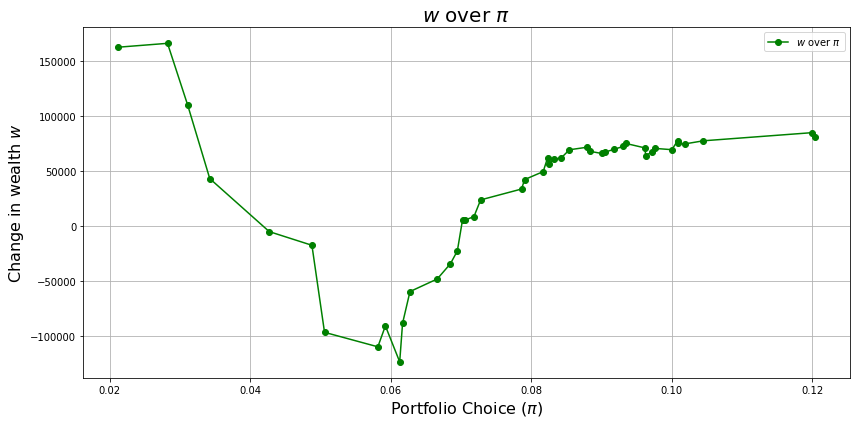

In [13]:
# Calculate the average wealth over id at each level of pi_H
average_w_over_pi = G_data.groupby('pi')['w'].mean()

# Apply a rolling window to smooth the average wealth over pi_H
window_size = 100
smoothed_average_w_over_pi = average_w_over_pi.rolling(window=window_size, min_periods=1).mean()

# Create the plot for 'w' on 'pi_H'
plt.figure(figsize=(12, 6))
plt.plot(smoothed_average_w_over_pi.index, smoothed_average_w_over_pi, label='$w$ over $\\pi$', color='green', marker='o')
plt.xlabel('Portfolio Choice ($\\pi$)', fontsize=16)
plt.ylabel('Change in wealth $w$', fontsize=16)
plt.title('$w$ over $\\pi$', fontsize=20)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Q-learning

## Define the reward function

In [14]:
# Define parameters
gamma = 0.95  # Discount factor
sigma = 0.85  # Risk aversion coefficient

### Options of Reward functions

In [15]:
# Option 1: CRRA

def utility(c, sigma):
    # CRRA utility function with parameter sigma
    if sigma == 1:
        return np.log(c)  # Log utility if sigma == 1
    else:
        return (c ** (1 - sigma)) / (1 - sigma)  # CRRA for sigma != 1


In [84]:
# Option 2: CARA

def utility(c, sigma):
    return -np.exp(-sigma * c)


In [259]:
# Option 3: DARA

def utility(c, sigma):
    return c**sigma

## Setting for Q_table

In [16]:
# Construct a grid of 100 possible pi values

import itertools

# Define the pi_grid and c_ratio_grid
pi_grid = np.linspace(0.01, 1.00, 10)
c_ratio_grid = np.linspace(0.01, 1.00, 10)

# Create the action space as a matrix of all combinations of pi and c_ratio
action_space = np.array(list(itertools.product(pi_grid, c_ratio_grid)))

# Display the action space
action_space[:10]  # Showing the first 10 combinations for brevity

array([[0.01, 0.01],
       [0.01, 0.12],
       [0.01, 0.23],
       [0.01, 0.34],
       [0.01, 0.45],
       [0.01, 0.56],
       [0.01, 0.67],
       [0.01, 0.78],
       [0.01, 0.89],
       [0.01, 1.  ]])

In [17]:
def initialize_Q_from_Q_0(GQ_data, action_space, gamma):
    # Initialize Q-table: for each household (id) and each (pi, c_ratio) pair, set Q-value to Q_0 + small random noise
    Q = {}
    
    # Loop over all unique household ids
    for household_id in GQ_data['id'].unique():
        # Get the Q_0 value for the household (since it's not time-varying, we can pick time=0)
        Q_0_value = GQ_data.loc[(GQ_data['id'] == household_id) & (GQ_data['time'] == 0), 'Q_0'].values[0]
        
        # Initialize Q-values for each (pi, c_ratio) pair in action_space
        Q[household_id] = {tuple(action): Q_0_value + np.random.uniform(-0.01, 0.01) for action in action_space}
    
    return Q


In [18]:
# Define constants
r_f = 0.05  # Risk-free rate
threshold = 100  # Convergence threshold

def update_Q(Q, household_id, last_selected_pi, pi_selected, utility_value, gamma, alpha):
    # Ensure the household has a Q dictionary initialized
    if household_id not in Q:
        Q[household_id] = {}

    Q_household = Q[household_id]

    # Calculate the max Q-value for the next state
    if Q_household:  # Check if the Q_household dictionary is not empty
        max_Q_value = max(Q_household.values())  # Maximum Q-value for future steps
    else:
        max_Q_value = 0  # Default value if no Q-values are set yet

    # Ensure that old_Q_value and max_Q_value are scalars
    old_Q_value = Q_household.get(last_selected_pi, 0)
    if isinstance(old_Q_value, pd.Series):
        old_Q_value = old_Q_value.iloc[0]  # Ensure it's a scalar

    if isinstance(utility_value, pd.Series):
        utility_value = utility_value.iloc[0]  # Ensure it's a scalar

    # Temporal difference update: Q_new = (1 - alpha) * Q_old + alpha * (reward + gamma * max_future_value)
    Q[household_id][pi_selected] = (1 - alpha) * old_Q_value + alpha * (utility_value + gamma * max_Q_value)

    # Compute the Q-value difference (to check for convergence)
    Q_diff = abs(old_Q_value - Q[household_id][pi_selected])

    # Ensure Q_diff is a scalar
    if isinstance(Q_diff, pd.Series):
        Q_diff = Q_diff.iloc[0]  # Extract scalar value

    # Print the Q-value change for debugging purposes
    print(f"Household {household_id}, pi = {pi_selected}, Q-value updated from {old_Q_value} to {Q[household_id][pi_selected]}, Q_diff = {Q_diff}")

    return Q_diff


In [19]:
def epsilon_greedy_update(epsilon, step, decay_rate=0.7, min_epsilon=0.1):

    # Update epsilon using exponential decay
    epsilon = max(min_epsilon, epsilon * decay_rate)
    return epsilon


## GQ-learning

In [20]:
# Step 1: OLS regression to predict pi[time=1] with k_vars

def predict_initial_pi(GQ_data, ols_model, last_selected_action, k_vars):
    # Update GQ_data's 'pi_lag' column with the values from last_selected_action (which contain pi) for each household
    GQ_data['pi_lag'] = GQ_data['id'].map({household_id: action[0] for household_id, action in last_selected_action.items()})
    
    # Replace NaN with 0 in relevant columns before prediction
    GQ_data[['pi_lag', 'L_y', 'L_s', 'r_f', 'e'] + k_vars] = GQ_data[['pi_lag', 'L_y', 'L_s', 'r_f', 'e'] + k_vars].fillna(0)

    # Predict the next pi using the ols_model
    GQ_data['predicted_pi'] = ols_model.predict(sm.add_constant(GQ_data[['pi_lag', 'L_y', 'L_s', 'r_f', 'CCA1', 'CCA2', 'e']+k_vars]))

    return GQ_data



In [21]:
# Step 2: The second stage predict of G-estimation with k_vars

def predict_w_y_for_selected_pi(GQ_data, pi_selected, last_selected_action, result_stage2, w, y, k_vars):
    # Ensure that pi_lag is correctly mapped from last_selected_action (extract pi from the action)
    GQ_data['pi_lag'] = GQ_data['id'].map({household_id: action[0] for household_id, action in last_selected_action.items()})

    # Add a constant to match the trained model, which includes a constant term
    prediction_data = sm.add_constant(GQ_data[['pi_lag', 'L_y', 'L_s', 'r_f', 'CCA1', 'CCA2', 'e']+k_vars], has_constant='add')

    # Predict the next pi using the ols_model
    GQ_data['predicted_pi'] = ols_model.predict(prediction_data)
    
    # Create interaction terms with the selected pi and pi_lag
    GQ_data['interaction_predicted_pi'] = GQ_data['predicted_pi'] * (1 + GQ_data['L_y'] + GQ_data['L_s'] + GQ_data['r_f']  + GQ_data['CCA1'] + GQ_data['CCA2'])
    GQ_data['interaction_pi'] = pi_selected * (1 + GQ_data['L_y'] + GQ_data['L_s'] + GQ_data['r_f'] + GQ_data['CCA1'] + GQ_data['CCA2'])
    
    # Check if the household and time step exist
    if GQ_data.empty or pd.isnull(w) or pd.isnull(y):
        raise ValueError(f"Missing or invalid data for household or time step: w={w}, y={y}")
    
    # Prepare the prediction data for the current household and time step
    prediction_data_stage2 = pd.DataFrame({
        'pi_lag': GQ_data['pi_lag'].iloc[0],  # Access the first element for the household
        'predicted_pi': GQ_data['predicted_pi'].iloc[0],
        'L_y': GQ_data['L_y'].iloc[0],
        'L_s': GQ_data['L_s'].iloc[0],
        'r_f': GQ_data['r_f'].iloc[0],
        'CCA1': GQ_data['CCA1'].iloc[0],
        'CCA2': GQ_data['CCA2'].iloc[0],
        'e': GQ_data['e'].iloc[0],
        'interaction_predicted_pi': GQ_data['interaction_predicted_pi'].iloc[0],
        'interaction_pi': GQ_data['interaction_pi'].iloc[0],
        'w': w,
        'y': y
    }, index=[0])  # Ensure it's a single row DataFrame for prediction
    
    
    # Add household-specific variables from k_vars
    for var in k_vars:
        prediction_data_stage2[var] = GQ_data[var].iloc[0]

    # Predict w and y using the second-stage models
    try:
        w_pred = result_stage2['w'].predict(prediction_data_stage2)
        y_pred = result_stage2['y'].predict(prediction_data_stage2)
    except Exception as e:
        raise ValueError(f"Prediction error: {e}")
    
    # Ensure predictions are scalars (single values)
    if isinstance(w_pred, pd.Series):
        w_pred = w_pred.iloc[0]
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.iloc[0]
    
    return w_pred, y_pred

In [22]:
# Check the variable names (columns) in GQ_data
print(GQ_data.columns)


Index(['id', 'time', 'pi', 'pi_lag', 'L_s', 'L_s_lag', 'r_s', 'r_f', 'y', 'w',
       'e', 'c', 'w_PSID', 'y_PSID', 'e_PSID', 'pi_PSID', 'L_y', 'CCA1',
       'CCA2', 'D_gender', 'D_black', 'D_married', 'D_college',
       'D_bus_fam_experience', 'D_stock', 'D_2house', 'D_own_or_rent',
       'D_balanced_invest', 'D_OwnSelfBus', 'D_bond_ann', 'D_educ', 'D_age',
       'Q_0'],
      dtype='object')


## Iteration

In [23]:
# Step 5: Epsilon-greedy iteration with k_vars

def iterate_gq_learning(GQ_data, action_space, gamma, epsilon, threshold, ols_model, result_stage2, sigma, alpha, k_vars):
    # Ensure initial values for w and y at time=0 are filled in GQ_data
    GQ_data.loc[GQ_data['time'] == 1, 'w'] = GQ_data['w'].fillna(GQ_data['w_PSID'])
    GQ_data.loc[GQ_data['time'] == 1, 'y'] = GQ_data['y'].fillna(GQ_data['y_PSID'])

    # Initialize Q-function using V from time=0 for each household instead of w_PSID
    Q = initialize_Q_from_Q_0(GQ_data, action_space, gamma)

    # Initialize action selection history for each household
    last_selected_action = {household_id: action_space[0] for household_id in GQ_data['id'].unique()}  # Initialize with the first action
    w = {household_id: GQ_data.loc[(GQ_data['id'] == household_id) & (GQ_data['time'] == 0), 'w'].values[0] for household_id in GQ_data['id'].unique()}
    y = {household_id: GQ_data.loc[(GQ_data['id'] == household_id) & (GQ_data['time'] == 0), 'y'].values[0] for household_id in GQ_data['id'].unique()}

    step = 1
    max_iterations = 163 # Set a max iteration count to avoid infinite loops

    while step < max_iterations:
        step += 1
        print(f"\nStarting iteration {step} (time step {step})...")

        all_converged = True  # Assume all households converge at first

        for household_id in GQ_data['id'].unique():
            # Get the current time step row for the household
            current_row = GQ_data[(GQ_data['id'] == household_id) & (GQ_data['time'] == step)]
            
            if current_row.empty:
                continue

            print(f"Processing household {household_id}, time[t]={step}...")

            # Epsilon-greedy exploration or exploitation
            if np.random.rand() < epsilon:
                action_index = np.random.randint(0, len(action_space))  # Randomly choose an action (pi, c_ratio)
                print(f"Exploring: Randomly selected action = {action_space[action_index]}")
            else:
                # Get the Q-values for the household
                Q_values_for_household = Q[household_id]

                # Get the Q-values for all actions in the action space
                Q_values_for_household = [Q_values_for_household[tuple(action)] for action in action_space]

                # Find the maximum Q-value
                max_Q_value = max(Q_values_for_household)

                # Select all actions with the maximum Q-value (to break ties)
                best_actions = [i for i, Q_value in enumerate(Q_values_for_household) if Q_value == max_Q_value]

                # Randomly select one of the best actions in case of ties
                action_index = np.random.choice(best_actions)
                print(f"Exploiting: Selected action = {action_space[action_index]} with max Q-value")


            pi_selected, c_ratio_selected = action_space[action_index]

            # Step 1: Predict w[t+1] and y[t+1] based on selected pi, using result_stage2 and the current state (w, y)
            w_pred, y_pred = predict_w_y_for_selected_pi(GQ_data, pi_selected, last_selected_action, result_stage2, w[household_id], y[household_id],k_vars)

            # Ensure w_pred and y_pred are valid
            if np.isnan(w_pred) or np.isnan(y_pred):
                print(f"NaN detected in predictions for household {household_id} at time step {step}")
                continue  # Skip this household for the current iteration if NaN is found

            # Step 2: Compute utility for selected action using the utility function based on consumption
            w_current = w[household_id]
            c_current = c_ratio_selected * w_current  # Consumption is based on c_ratio

            # Ensure c is positive
            c_current = np.maximum(c_current, 1e-8)

            # Calculate utility
            utility_value = utility(c_current, sigma)

            # Ensure utility is a scalar
            if isinstance(utility_value, (np.ndarray, pd.Series)):
                utility_value = utility_value.item()  # Convert to scalar if needed

            # Step 3: Update GQ_data with selected action, w, y, and c at the current and next time step
            next_time = step + 1

            # Store the selected pi, w, y, and consumption (c) for the current time step
            GQ_data.loc[(GQ_data['id'] == household_id) & (GQ_data['time'] == step), 'pi'] = pi_selected
            GQ_data.loc[(GQ_data['id'] == household_id) & (GQ_data['time'] == step), 'c'] = c_current

            # Store the predicted w and y for the next time step
            GQ_data.loc[(GQ_data['id'] == household_id) & (GQ_data['time'] == next_time), 'w'] = w_pred
            GQ_data.loc[(GQ_data['id'] == household_id) & (GQ_data['time'] == next_time), 'y'] = y_pred
            GQ_data.loc[(GQ_data['id'] == household_id) & (GQ_data['time'] == next_time), 'pi_lag'] = pi_selected

            # Update the last predicted w and y for the household for the next iteration
            w[household_id] = w_pred
            y[household_id] = y_pred

            # Step 4: Update Q-values for this household, only for the selected action
            Q_diff = update_Q(Q, household_id, tuple(last_selected_action[household_id]), (pi_selected, c_ratio_selected), utility_value, gamma, alpha)

            # Print the Q-value difference for debugging
            print(f"Household {household_id}: Q_diff = {Q_diff}")

            # Store the current selected action for use in the next iteration
            last_selected_action[household_id] = (pi_selected, c_ratio_selected)

            # Step 5: Check if the household has converged based on Q_diff
            if Q_diff > threshold:
                all_converged = False  # If the difference is too large, the household hasn't converged

        # Re-predict pi using OLS regression based on updated pi_lag
        GQ_data = predict_initial_pi(GQ_data, ols_model, last_selected_action, k_vars)

        # Decay epsilon
        epsilon = epsilon_greedy_update(epsilon, step, decay_rate=0.99, min_epsilon=0.1)
        print(f"Updated epsilon: {epsilon}")

        # If all households have converged, break out of the loop
        if all_converged:
            print(f"All households have converged at step {step}. Ending iterations.")
            break

        # Continue to the next iteration even if not all households have converged
        print(f"Some households haven't converged. Continuing to next iteration.")

    # After max_iterations or convergence, store the final pi, w, y, and c in the GQ_data columns
    GQ_data['pi_GQ'] = GQ_data['pi']
    GQ_data['w_GQ'] = GQ_data['w']
    GQ_data['y_GQ'] = GQ_data['y']
    GQ_data['c_GQ'] = GQ_data['c']
    
    # After the loop ends, create PSID_initial_Q with the final Q values for each household
    PSID_initial_Q = pd.DataFrame({
        'id': list(Q.keys()),
        'Q_value': [max(Q[household_id].values()) for household_id in Q]
    })    
    return GQ_data, PSID_initial_Q


## Implement the learning

In [24]:
GQ_data.head()

,id,time,pi,pi_lag,L_s,L_s_lag,r_s,r_f,y,w,...,D_bus_fam_experience,D_stock,D_2house,D_own_or_rent,D_balanced_invest,D_OwnSelfBus,D_bond_ann,D_educ,D_age,Q_0
0,1,0,0.014483,0.031578,1282.618500,865.575500,0.481810,0.146757,66405.222472,-847646.568539,...,0.0033,0.044944,0.20462,0.442697,0.060674,0.20462,0.01573,15.313531,47.220225,62415.473951
1,1,1,NaN,0.014483,1321.117888,1282.618500,0.030016,0.126786,66405.222472,-847646.568539,...,0.0033,0.044944,0.20462,0.442697,0.060674,0.20462,0.01573,15.313531,47.220225,62415.473951
2,1,2,NaN,NaN,1304.486514,1321.117888,-0.012589,0.094826,NaN,NaN,...,0.0033,0.044944,0.20462,0.442697,0.060674,0.20462,0.01573,15.313531,47.220225,62415.473951
3,1,3,NaN,NaN,1331.505011,1304.486514,0.020712,0.055306,NaN,NaN,...,0.0033,0.044944,0.20462,0.442697,0.060674,0.20462,0.01573,15.313531,47.220225,62415.473951
4,1,4,NaN,NaN,1338.310465,1331.505011,0.005111,0.036818,NaN,NaN,...,0.0033,0.044944,0.20462,0.442697,0.060674,0.20462,0.01573,15.313531,47.220225,62415.473951


In [25]:
if __name__ == "__main__":
    # Define constants
    sigma = 0.85  # Risk aversion coefficient
    alpha = 0.2  # Learning rate for Q-learning updates
    gamma = 0.8  # Discount factor
    epsilon = 0.3  # Initial epsilon for epsilon-greedy exploration
    threshold = 0.01
      # Convergence threshold
        
     # Define household-specific variables (k_vars) that are consistent across GQ_data and G_data
    #k_vars = ["D_bus_fam_experience", "D_stock", "D_college", "D_2house","D_gender", "D_black", "D_married", "D_own_or_rent","D_bond_ann","D_balanced_invest","D_OwnSelfBus","D_educ", "D_age"]
    k_vars = ["D_gender",'D_married',"D_educ",'D_own_or_rent','D_balanced_invest',"D_bus_fam_experience",'D_2house'] # keep align with definition in G-estimation

    # Construct the grid of possible pi values (action space)
    pi_grid = np.linspace(0.02, 0.18, 100)
    c_ratio_grid = np.linspace(0.3, 0.8, 100)

    # Create the action space as a combination of pi and c_ratio pairs
    action_space = np.array(list(itertools.product(pi_grid, c_ratio_grid)))

    # Run the Q-learning iteration process
    GQ_data, PSID_initial_Q = iterate_gq_learning(
        GQ_data=GQ_data, 
        action_space=action_space,  # Pass the pi, c_ratio pairs as action space
        gamma=gamma, 
        epsilon=epsilon, 
        threshold=threshold, 
        ols_model=ols_model,  # Pass the trained OLS model here
        result_stage2=result_stage2,  # Fitted OLS models for w and y predictions
        sigma=sigma, 
        alpha=alpha,
        k_vars=k_vars
    )
    
    # Display the final GQ_data with optimal pi_GQ, w_GQ, y_GQ, and c_GQ columns
    print(GQ_data[['pi_GQ', 'w_GQ', 'y_GQ', 'c_GQ']].head())



Starting iteration 2 (time step 2)...
Processing household 1, time[t]=2...
Exploring: Randomly selected action = [0.15414141 0.47171717]
Household 1, pi = (0.15414141414141413, 0.47171717171717176), Q-value updated from 62415.47852902085 to 59918.944382967195, Q_diff = 2496.5341460536583
Household 1: Q_diff = 2496.5341460536583
Processing household 2, time[t]=2...
Exploiting: Selected action = [0.02484848 0.66363636] with max Q-value
Household 2, pi = (0.02484848484848485, 0.6636363636363636), Q-value updated from 59906.383601554146 to 57516.30089610207, Q_diff = 2390.082705452078
Household 2: Q_diff = 2390.082705452078
Processing household 3, time[t]=2...
Exploring: Randomly selected action = [0.13151515 0.33535354]
Household 3, pi = (0.1315151515151515, 0.33535353535353535), Q-value updated from 74894.50798395764 to 71905.32268087051, Q_diff = 2989.185303087128
Household 3: Q_diff = 2989.185303087128
Processing household 4, time[t]=2...
Exploiting: Selected action = [0.12666667 0.42

Household 2, pi = (0.1703030303030303, 0.7595959595959596), Q-value updated from 51886.200082227435 to 51105.34448670842, Q_diff = 780.8555955190168
Household 2: Q_diff = 780.8555955190168
Processing household 3, time[t]=7...
Exploiting: Selected action = [0.14767677 0.46161616] with max Q-value
Household 3, pi = (0.14767676767676766, 0.4616161616161616), Q-value updated from 64858.437293615236 to 63880.404440807535, Q_diff = 978.0328528077007
Household 3: Q_diff = 978.0328528077007
Processing household 4, time[t]=7...
Exploring: Randomly selected action = [0.05070707 0.40606061]
Household 4, pi = (0.05070707070707071, 0.40606060606060607), Q-value updated from 91789.11893648474 to 90402.89082209174, Q_diff = 1386.2281143930013
Household 4: Q_diff = 1386.2281143930013
Processing household 5, time[t]=7...
Exploring: Randomly selected action = [0.03777778 0.3       ]
Household 5, pi = (0.03777777777777778, 0.3), Q-value updated from 224380.0676312233 to 220985.48655889605, Q_diff = 3394.

Exploiting: Selected action = [0.14444444 0.50707071] with max Q-value
Household 3, pi = (0.14444444444444443, 0.5070707070707071), Q-value updated from 61571.7958304646 to 61251.31365564632, Q_diff = 320.4821748182803
Household 3: Q_diff = 320.4821748182803
Processing household 4, time[t]=12...
Exploring: Randomly selected action = [0.16222222 0.56262626]
Household 4, pi = (0.1622222222222222, 0.5626262626262626), Q-value updated from 87131.34312373305 to 86677.23992100566, Q_diff = 454.10320272739045
Household 4: Q_diff = 454.10320272739045
Processing household 5, time[t]=12...
Exploiting: Selected action = [0.12181818 0.70909091] with max Q-value
Household 5, pi = (0.12181818181818183, 0.7090909090909091), Q-value updated from 212971.61724557646 to 211860.15299696926, Q_diff = 1111.464248607197
Household 5: Q_diff = 1111.464248607197
Updated epsilon: 0.2686014762776149
Some households haven't converged. Continuing to next iteration.

Starting iteration 13 (time step 13)...
Processin

Household 5, pi = (0.08464646464646465, 0.3909090909090909), Q-value updated from 209235.0877174514 to 208869.95192750456, Q_diff = 365.1357899468276
Household 5: Q_diff = 365.1357899468276
Updated epsilon: 0.25543733132846264
Some households haven't converged. Continuing to next iteration.

Starting iteration 18 (time step 18)...
Processing household 1, time[t]=18...
Exploiting: Selected action = [0.13151515 0.66868687] with max Q-value
Household 1, pi = (0.1315151515151515, 0.6686868686868688), Q-value updated from 50335.280982679615 to 50265.8590949853, Q_diff = 69.42188769431232
Household 1: Q_diff = 69.42188769431232
Processing household 2, time[t]=18...
Exploiting: Selected action = [0.11858586 0.77474747] with max Q-value
Household 2, pi = (0.11858585858585859, 0.7747474747474747), Q-value updated from 48314.478503545084 to 48248.10757407949, Q_diff = 66.37092946559278
Household 2: Q_diff = 66.37092946559278
Processing household 3, time[t]=18...
Exploiting: Selected action = [0.

Household 1, pi = (0.14767676767676766, 0.6181818181818182), Q-value updated from 50101.08388234231 to 50078.37158052621, Q_diff = 22.71230181610008
Household 1: Q_diff = 22.71230181610008
Processing household 2, time[t]=23...
Exploiting: Selected action = [0.14606061 0.75454545] with max Q-value
Household 2, pi = (0.14606060606060606, 0.7545454545454546), Q-value updated from 48089.11471380794 to 48067.66370587273, Q_diff = 21.451007935211237
Household 2: Q_diff = 21.451007935211237
Processing household 3, time[t]=23...
Exploiting: Selected action = [0.14929293 0.51212121] with max Q-value
Household 3, pi = (0.14929292929292928, 0.5121212121212121), Q-value updated from 60107.2911866313 to 60079.642564429814, Q_diff = 27.648622201486432
Household 3: Q_diff = 27.648622201486432
Processing household 4, time[t]=23...
Exploiting: Selected action = [0.04585859 0.46161616] with max Q-value
Household 4, pi = (0.04585858585858586, 0.4616161616161616), Q-value updated from 85056.28652581852 to

Household 2, pi = (0.08626262626262626, 0.47171717171717176), Q-value updated from 48014.95717082545 to 48007.61398425594, Q_diff = 7.343186569509271
Household 2: Q_diff = 7.343186569509271
Processing household 3, time[t]=28...
Exploring: Randomly selected action = [0.05070707 0.44141414]
Household 3, pi = (0.05070707070707071, 0.4414141414141414), Q-value updated from 60015.32188546012 to 60005.91460462101, Q_diff = 9.40728083911381
Household 3: Q_diff = 9.40728083911381
Processing household 4, time[t]=28...
Exploiting: Selected action = [0.17676768 0.69393939] with max Q-value
Household 4, pi = (0.17676767676767677, 0.693939393939394), Q-value updated from 84924.8119042868 to 84912.38752939535, Q_diff = 12.424374891459593
Household 4: Q_diff = 12.424374891459593
Processing household 5, time[t]=28...
Exploring: Randomly selected action = [0.0410101  0.33030303]
Household 5, pi = (0.04101010101010101, 0.3303030303030303), Q-value updated from 207568.5953323592 to 207536.48128003537, Q_

Household 4, pi = (0.11696969696969697, 0.5171717171717172), Q-value updated from 84882.06656194168 to 84877.76531980652, Q_diff = 4.301242135159555
Household 4: Q_diff = 4.301242135159555
Processing household 5, time[t]=33...
Exploiting: Selected action = [0.12181818 0.48686869] with max Q-value
Household 5, pi = (0.12181818181818183, 0.4868686868686869), Q-value updated from 207463.26072071385 to 207452.89357534552, Q_diff = 10.367145368334604
Household 5: Q_diff = 10.367145368334604
Updated epsilon: 0.217494100787356
Some households haven't converged. Continuing to next iteration.

Starting iteration 34 (time step 34)...
Processing household 1, time[t]=34...
Exploiting: Selected action = [0.16222222 0.50707071] with max Q-value
Household 1, pi = (0.1622222222222222, 0.5070707070707071), Q-value updated from 49996.30236125749 to 49994.32831235228, Q_diff = 1.9740489052128396
Household 1: Q_diff = 1.9740489052128396
Processing household 2, time[t]=34...
Exploiting: Selected action = [

Exploiting: Selected action = [0.14282828 0.71414141] with max Q-value
Household 2, pi = (0.14282828282828283, 0.7141414141414142), Q-value updated from 47981.18217966212 to 47981.262439527025, Q_diff = 0.08025986490247305
Household 2: Q_diff = 0.08025986490247305
Processing household 3, time[t]=39...
Exploiting: Selected action = [0.11050505 0.58787879] with max Q-value
Household 3, pi = (0.11050505050505051, 0.5878787878787879), Q-value updated from 59972.635723417814 to 59972.18825659956, Q_diff = 0.4474668182519963
Household 3: Q_diff = 0.4474668182519963
Processing household 4, time[t]=39...
Exploiting: Selected action = [0.07333333 0.62828283] with max Q-value
Household 4, pi = (0.07333333333333333, 0.6282828282828283), Q-value updated from 84866.44803603317 to 84865.49898567934, Q_diff = 0.9490503538254416
Household 4: Q_diff = 0.9490503538254416
Processing household 5, time[t]=39...
Exploiting: Selected action = [0.0830303  0.74949495] with max Q-value
Household 5, pi = (0.0830

Household 2, pi = (0.16383838383838384, 0.3303030303030303), Q-value updated from 47979.72475267368 to 47978.817264169484, Q_diff = 0.9074885041991365
Household 2: Q_diff = 0.9074885041991365
Processing household 3, time[t]=44...
Exploiting: Selected action = [0.09111111 0.37575758] with max Q-value
Household 3, pi = (0.09111111111111111, 0.37575757575757573), Q-value updated from 59970.85367372174 to 59969.995027786026, Q_diff = 0.8586459357102285
Household 3: Q_diff = 0.8586459357102285
Processing household 4, time[t]=44...
Exploiting: Selected action = [0.03777778 0.69393939] with max Q-value
Household 4, pi = (0.03777777777777778, 0.693939393939394), Q-value updated from 84861.69907283854 to 84861.83828467173, Q_diff = 0.13921183318598196
Household 4: Q_diff = 0.13921183318598196
Processing household 5, time[t]=44...
Exploring: Randomly selected action = [0.05878788 0.37070707]
Household 5, pi = (0.05878787878787879, 0.3707070707070707), Q-value updated from 207416.9253205549 to 20

Household 3, pi = (0.09595959595959597, 0.6383838383838384), Q-value updated from 59969.151762327994 to 59969.50144707934, Q_diff = 0.34968475134519394
Household 3: Q_diff = 0.34968475134519394
Processing household 4, time[t]=49...
Exploiting: Selected action = [0.14606061 0.53232323] with max Q-value
Household 4, pi = (0.14606060606060606, 0.5323232323232323), Q-value updated from 84860.5475640061 to 84860.4366587857, Q_diff = 0.11090522041195072
Household 4: Q_diff = 0.11090522041195072
Processing household 5, time[t]=49...
Exploiting: Selected action = [0.12666667 0.67878788] with max Q-value
Household 5, pi = (0.12666666666666665, 0.6787878787878788), Q-value updated from 207412.90862867824 to 207413.00984434373, Q_diff = 0.10121566549059935
Household 5: Q_diff = 0.10121566549059935
Updated epsilon: 0.18518704228268634
Some households haven't converged. Continuing to next iteration.

Starting iteration 50 (time step 50)...
Processing household 1, time[t]=50...
Exploiting: Selected 

Household 4, pi = (0.04585858585858586, 0.6737373737373737), Q-value updated from 84860.65106804666 to 84860.98957465672, Q_diff = 0.3385066100599943
Household 4: Q_diff = 0.3385066100599943
Processing household 5, time[t]=54...
Exploiting: Selected action = [0.08626263 0.41616162] with max Q-value
Household 5, pi = (0.08626262626262626, 0.4161616161616162), Q-value updated from 207411.9912866491 to 207411.56456668905, Q_diff = 0.42671996005810797
Household 5: Q_diff = 0.42671996005810797
Updated epsilon: 0.17611103458124527
Some households haven't converged. Continuing to next iteration.

Starting iteration 55 (time step 55)...
Processing household 1, time[t]=55...
Exploiting: Selected action = [0.09757576 0.65858586] with max Q-value
Household 1, pi = (0.09757575757575758, 0.6585858585858586), Q-value updated from 49986.34299957875 to 49986.68734237069, Q_diff = 0.3443427919410169
Household 1: Q_diff = 0.3443427919410169
Processing household 2, time[t]=55...
Exploiting: Selected acti

Exploiting: Selected action = [0.03939394 0.41616162] with max Q-value
Household 1, pi = (0.0393939393939394, 0.4161616161616162), Q-value updated from 49986.02403578625 to 49985.704436598484, Q_diff = 0.3195991877655615
Household 1: Q_diff = 0.3195991877655615
Processing household 2, time[t]=60...
Exploiting: Selected action = [0.12666667 0.53737374] with max Q-value
Household 2, pi = (0.12666666666666665, 0.5373737373737374), Q-value updated from 47978.34577325139 to 47978.49015812371, Q_diff = 0.14438487232109765
Household 2: Q_diff = 0.14438487232109765
Processing household 3, time[t]=60...
Exploiting: Selected action = [0.02646465 0.72424242] with max Q-value
Household 3, pi = (0.026464646464646465, 0.7242424242424242), Q-value updated from 59970.03232420672 to 59970.43703554588, Q_diff = 0.40471133916435065
Household 3: Q_diff = 0.40471133916435065
Processing household 4, time[t]=60...
Exploiting: Selected action = [0.13959596 0.42121212] with max Q-value
Household 4, pi = (0.139

Household 3, pi = (0.17515151515151514, 0.47171717171717176), Q-value updated from 59970.24753049928 to 59969.87338505246, Q_diff = 0.3741454468181473
Household 3: Q_diff = 0.3741454468181473
Processing household 4, time[t]=65...
Exploiting: Selected action = [0.08464646 0.6989899 ] with max Q-value
Household 4, pi = (0.08464646464646465, 0.698989898989899), Q-value updated from 84859.37635179023 to 84860.01228405876, Q_diff = 0.6359322685311781
Household 4: Q_diff = 0.6359322685311781
Processing household 5, time[t]=65...
Exploiting: Selected action = [0.07010101 0.6030303 ] with max Q-value
Household 5, pi = (0.07010101010101011, 0.603030303030303), Q-value updated from 207411.48630956968 to 207411.71797301303, Q_diff = 0.23166344335186295
Household 5: Q_diff = 0.23166344335186295
Updated epsilon: 0.15767894625766857
Some households haven't converged. Continuing to next iteration.

Starting iteration 66 (time step 66)...
Processing household 1, time[t]=66...
Exploiting: Selected acti

Household 4, pi = (0.13636363636363635, 0.7747474747474747), Q-value updated from 84860.36977350846 to 84860.90567211155, Q_diff = 0.5358986030914821
Household 4: Q_diff = 0.5358986030914821
Processing household 5, time[t]=70...
Exploring: Randomly selected action = [0.05717172 0.47171717]
Household 5, pi = (0.05717171717171718, 0.47171717171717176), Q-value updated from 207410.82945532864 to 207410.76574713655, Q_diff = 0.06370819208677858
Household 5: Q_diff = 0.06370819208677858
Updated epsilon: 0.14995110896975963
Some households haven't converged. Continuing to next iteration.

Starting iteration 71 (time step 71)...
Processing household 1, time[t]=71...
Exploiting: Selected action = [0.05393939 0.52727273] with max Q-value
Household 1, pi = (0.05393939393939394, 0.5272727272727273), Q-value updated from 49985.491283747266 to 49985.58478305294, Q_diff = 0.09349930567259435
Household 1: Q_diff = 0.09349930567259435
Processing household 2, time[t]=71...
Exploiting: Selected action =

Exploiting: Selected action = [0.17353535 0.68383838] with max Q-value
Household 1, pi = (0.17353535353535351, 0.6838383838383839), Q-value updated from 49987.42210643754 to 49987.55104700731, Q_diff = 0.12894056977529544
Household 1: Q_diff = 0.12894056977529544
Processing household 2, time[t]=76...
Exploiting: Selected action = [0.17191919 0.75959596] with max Q-value
Household 2, pi = (0.17191919191919192, 0.7595959595959596), Q-value updated from 47978.37086978878 to 47979.184804237906, Q_diff = 0.8139344491282827
Household 2: Q_diff = 0.8139344491282827
Processing household 3, time[t]=76...
Exploiting: Selected action = [0.14767677 0.54242424] with max Q-value
Household 3, pi = (0.14767676767676766, 0.5424242424242425), Q-value updated from 59969.39314675966 to 59969.536126726874, Q_diff = 0.14297996721143136
Household 3: Q_diff = 0.14297996721143136
Processing household 4, time[t]=76...
Exploiting: Selected action = [0.04262626 0.56262626] with max Q-value
Household 4, pi = (0.04

Household 2, pi = (0.04909090909090909, 0.34545454545454546), Q-value updated from 47979.83937076729 to 47978.97688826289, Q_diff = 0.8624825043953024
Household 2: Q_diff = 0.8624825043953024
Processing household 3, time[t]=81...
Exploiting: Selected action = [0.1040404  0.42121212] with max Q-value
Household 3, pi = (0.10404040404040404, 0.4212121212121212), Q-value updated from 59969.02430051088 to 59968.75565052528, Q_diff = 0.2686499855990405
Household 3: Q_diff = 0.2686499855990405
Processing household 4, time[t]=81...
Exploring: Randomly selected action = [0.07171717 0.75454545]
Household 4, pi = (0.07171717171717172, 0.7545454545454546), Q-value updated from 84860.1940366481 to 84860.76477979668, Q_diff = 0.570743148578913
Household 4: Q_diff = 0.570743148578913
Processing household 5, time[t]=81...
Exploiting: Selected action = [0.03292929 0.61313131] with max Q-value
Household 5, pi = (0.03292929292929293, 0.6131313131313132), Q-value updated from 207411.15101830417 to 207411.

Household 3, pi = (0.14282828282828283, 0.6484848484848484), Q-value updated from 59969.11341102916 to 59969.58076977784, Q_diff = 0.4673587486759061
Household 3: Q_diff = 0.4673587486759061
Processing household 4, time[t]=86...
Exploiting: Selected action = [0.07656566 0.67373737] with max Q-value
Household 4, pi = (0.07656565656565657, 0.6737373737373737), Q-value updated from 84859.65649594189 to 84860.22715356083, Q_diff = 0.5706576189404586
Household 4: Q_diff = 0.5706576189404586
Processing household 5, time[t]=86...
Exploring: Randomly selected action = [0.02484848 0.48686869]
Household 5, pi = (0.02484848484848485, 0.4868686868686869), Q-value updated from 207411.21054779532 to 207411.19177931844, Q_diff = 0.01876847687526606
Household 5: Q_diff = 0.01876847687526606
Updated epsilon: 0.12767703701659638
Some households haven't converged. Continuing to next iteration.

Starting iteration 87 (time step 87)...
Processing household 1, time[t]=87...
Exploiting: Selected action = [0.

Household 3, pi = (0.11858585858585859, 0.7494949494949495), Q-value updated from 59970.93135252135 to 59971.177679274246, Q_diff = 0.24632675289467443
Household 3: Q_diff = 0.24632675289467443
Processing household 4, time[t]=91...
Exploiting: Selected action = [0.16707071 0.68888889] with max Q-value
Household 4, pi = (0.16707070707070706, 0.6888888888888889), Q-value updated from 84860.945095925 to 84861.22151187382, Q_diff = 0.2764159488287987
Household 4: Q_diff = 0.2764159488287987
Processing household 5, time[t]=91...
Exploiting: Selected action = [0.12343434 0.37575758] with max Q-value
Household 5, pi = (0.12343434343434344, 0.37575757575757573), Q-value updated from 207411.59893883864 to 207411.02262314263, Q_diff = 0.5763156960019842
Household 5: Q_diff = 0.5763156960019842
Updated epsilon: 0.12141959180349712
Some households haven't converged. Continuing to next iteration.

Starting iteration 92 (time step 92)...
Processing household 1, time[t]=92...
Exploiting: Selected act

Household 4, pi = (0.05555555555555555, 0.42626262626262623), Q-value updated from 84860.76661872205 to 84860.26756540408, Q_diff = 0.49905331796617247
Household 4: Q_diff = 0.49905331796617247
Processing household 5, time[t]=96...
Exploiting: Selected action = [0.13474747 0.78484848] with max Q-value
Household 5, pi = (0.13474747474747475, 0.7848484848484849), Q-value updated from 207411.6635866857 to 207412.28668584736, Q_diff = 0.62309916166123
Household 5: Q_diff = 0.62309916166123
Updated epsilon: 0.11546882366804535
Some households haven't converged. Continuing to next iteration.

Starting iteration 97 (time step 97)...
Processing household 1, time[t]=97...
Exploiting: Selected action = [0.1040404  0.73939394] with max Q-value
Household 1, pi = (0.10404040404040404, 0.7393939393939395), Q-value updated from 49986.55969112696 to 49987.016383297916, Q_diff = 0.4566921709556482
Household 1: Q_diff = 0.4566921709556482
Processing household 2, time[t]=97...
Exploring: Randomly selecte

Exploiting: Selected action = [0.11373737 0.77979798] with max Q-value
Household 1, pi = (0.11373737373737373, 0.7797979797979798), Q-value updated from 49987.11748539691 to 49987.54039701612, Q_diff = 0.4229116192072979
Household 1: Q_diff = 0.4229116192072979
Processing household 2, time[t]=102...
Exploiting: Selected action = [0.02646465 0.5979798 ] with max Q-value
Household 2, pi = (0.026464646464646465, 0.5979797979797981), Q-value updated from 47977.68067264003 to 47978.19614347653, Q_diff = 0.5154708365007536
Household 2: Q_diff = 0.5154708365007536
Processing household 3, time[t]=102...
Exploiting: Selected action = [0.15414141 0.79494949] with max Q-value
Household 3, pi = (0.15414141414141413, 0.794949494949495), Q-value updated from 59971.06398779356 to 59971.46095735184, Q_diff = 0.3969695582782151
Household 3: Q_diff = 0.3969695582782151
Processing household 4, time[t]=102...
Exploiting: Selected action = [0.05070707 0.62323232] with max Q-value
Household 4, pi = (0.05070

Exploiting: Selected action = [0.17838384 0.42121212] with max Q-value
Household 1, pi = (0.17838383838383837, 0.4212121212121212), Q-value updated from 49987.40274425955 to 49986.89922930591, Q_diff = 0.5035149536342942
Household 1: Q_diff = 0.5035149536342942
Processing household 2, time[t]=107...
Exploiting: Selected action = [0.05878788 0.34545455] with max Q-value
Household 2, pi = (0.05878787878787879, 0.34545454545454546), Q-value updated from 47979.61619202282 to 47978.7989385081, Q_diff = 0.8172535147168674
Household 2: Q_diff = 0.8172535147168674
Processing household 3, time[t]=107...
Exploiting: Selected action = [0.05070707 0.54747475] with max Q-value
Household 3, pi = (0.05070707070707071, 0.5474747474747474), Q-value updated from 59969.60254019985 to 59969.643287402396, Q_diff = 0.04074720254720887
Household 3: Q_diff = 0.04074720254720887
Processing household 4, time[t]=107...
Exploiting: Selected action = [0.1040404  0.62323232] with max Q-value
Household 4, pi = (0.10

Household 2, pi = (0.06525252525252526, 0.5929292929292929), Q-value updated from 47979.069742051484 to 47979.249150951415, Q_diff = 0.1794088999304222
Household 2: Q_diff = 0.1794088999304222
Processing household 3, time[t]=112...
Exploiting: Selected action = [0.09757576 0.44646465] with max Q-value
Household 3, pi = (0.09757575757575758, 0.44646464646464645), Q-value updated from 59970.40770426551 to 59969.96291862393, Q_diff = 0.44478564157907385
Household 3: Q_diff = 0.44478564157907385
Processing household 4, time[t]=112...
Exploiting: Selected action = [0.07333333 0.41616162] with max Q-value
Household 4, pi = (0.07333333333333333, 0.4161616161616162), Q-value updated from 84860.72518610636 to 84860.28253686018, Q_diff = 0.44264924617891666
Household 4: Q_diff = 0.44264924617891666
Processing household 5, time[t]=112...
Exploiting: Selected action = [0.11050505 0.3       ] with max Q-value
Household 5, pi = (0.11050505050505051, 0.3), Q-value updated from 207411.1484762132 to 20

Household 3, pi = (0.08626262626262626, 0.7696969696969698), Q-value updated from 59970.75002214812 to 59971.122038657304, Q_diff = 0.37201650918723317
Household 3: Q_diff = 0.37201650918723317
Processing household 4, time[t]=117...
Exploiting: Selected action = [0.08787879 0.49191919] with max Q-value
Household 4, pi = (0.08787878787878788, 0.4919191919191919), Q-value updated from 84861.83399822391 to 84861.38429473023, Q_diff = 0.449703493679408
Household 4: Q_diff = 0.449703493679408
Processing household 5, time[t]=117...
Exploiting: Selected action = [0.02969697 0.74444444] with max Q-value
Household 5, pi = (0.029696969696969697, 0.7444444444444445), Q-value updated from 207411.35723283174 to 207411.99125830826, Q_diff = 0.634025476523675
Household 5: Q_diff = 0.634025476523675
Updated epsilon: 0.1
Some households haven't converged. Continuing to next iteration.

Starting iteration 118 (time step 118)...
Processing household 1, time[t]=118...
Exploiting: Selected action = [0.1347

Household 5, pi = (0.13636363636363635, 0.4313131313131313), Q-value updated from 207412.14519006023 to 207411.7087770681, Q_diff = 0.43641299213049933
Household 5: Q_diff = 0.43641299213049933
Updated epsilon: 0.1
Some households haven't converged. Continuing to next iteration.

Starting iteration 123 (time step 123)...
Processing household 1, time[t]=123...
Exploiting: Selected action = [0.03616162 0.65858586] with max Q-value
Household 1, pi = (0.03616161616161616, 0.6585858585858586), Q-value updated from 49985.9214722071 to 49986.32623977884, Q_diff = 0.40476757174474187
Household 1: Q_diff = 0.40476757174474187
Processing household 2, time[t]=123...
Exploiting: Selected action = [0.04585859 0.46161616] with max Q-value
Household 2, pi = (0.04585858585858586, 0.4616161616161616), Q-value updated from 47980.326774189656 to 47979.85657455765, Q_diff = 0.47019963200727943
Household 2: Q_diff = 0.47019963200727943
Processing household 3, time[t]=123...
Exploiting: Selected action = [0

Updated epsilon: 0.1
Some households haven't converged. Continuing to next iteration.

Starting iteration 128 (time step 128)...
Processing household 1, time[t]=128...
Exploiting: Selected action = [0.04747475 0.49191919] with max Q-value
Household 1, pi = (0.047474747474747475, 0.4919191919191919), Q-value updated from 49986.324603266905 to 49986.24936334211, Q_diff = 0.07523992479400476
Household 1: Q_diff = 0.07523992479400476
Processing household 2, time[t]=128...
Exploiting: Selected action = [0.03131313 0.64848485] with max Q-value
Household 2, pi = (0.031313131313131314, 0.6484848484848484), Q-value updated from 47979.19279836613 to 47979.4944976842, Q_diff = 0.3016993180717691
Household 2: Q_diff = 0.3016993180717691
Processing household 3, time[t]=128...
Exploiting: Selected action = [0.18       0.37070707] with max Q-value
Household 3, pi = (0.18, 0.3707070707070707), Q-value updated from 59970.1169848631 to 59969.45140273435, Q_diff = 0.665582128756796
Household 3: Q_diff = 

Exploiting: Selected action = [0.02646465 0.43636364] with max Q-value
Household 1, pi = (0.026464646464646465, 0.4363636363636364), Q-value updated from 49985.39121435229 to 49985.26054141759, Q_diff = 0.13067293469794095
Household 1: Q_diff = 0.13067293469794095
Processing household 2, time[t]=133...
Exploring: Randomly selected action = [0.05717172 0.66363636]
Household 2, pi = (0.05717171717171718, 0.6636363636363636), Q-value updated from 47980.78343601992 to 47980.80938253695, Q_diff = 0.025946517031115945
Household 2: Q_diff = 0.025946517031115945
Processing household 3, time[t]=133...
Exploiting: Selected action = [0.07656566 0.58282828] with max Q-value
Household 3, pi = (0.07656565656565657, 0.5828282828282829), Q-value updated from 59968.85586455453 to 59969.146209546, Q_diff = 0.2903449914738303
Household 3: Q_diff = 0.2903449914738303
Processing household 4, time[t]=133...
Exploiting: Selected action = [0.11535354 0.4969697 ] with max Q-value
Household 4, pi = (0.115353535

Household 3, pi = (0.029696969696969697, 0.40101010101010104), Q-value updated from 59969.94923473352 to 59969.4466085877, Q_diff = 0.5026261458187946
Household 3: Q_diff = 0.5026261458187946
Processing household 4, time[t]=138...
Exploiting: Selected action = [0.12828283 0.62323232] with max Q-value
Household 4, pi = (0.12828282828282828, 0.6232323232323232), Q-value updated from 84860.9318314872 to 84861.05571258554, Q_diff = 0.12388109833409544
Household 4: Q_diff = 0.12388109833409544
Processing household 5, time[t]=138...
Exploiting: Selected action = [0.07494949 0.51212121] with max Q-value
Household 5, pi = (0.07494949494949495, 0.5121212121212121), Q-value updated from 207413.08986696074 to 207412.74843658626, Q_diff = 0.34143037447938696
Household 5: Q_diff = 0.34143037447938696
Updated epsilon: 0.1
Some households haven't converged. Continuing to next iteration.

Starting iteration 139 (time step 139)...
Processing household 1, time[t]=139...
Exploiting: Selected action = [0.

Household 4, pi = (0.034545454545454546, 0.6484848484848484), Q-value updated from 84861.0392770672 to 84861.1719555025, Q_diff = 0.13267843530047685
Household 4: Q_diff = 0.13267843530047685
Processing household 5, time[t]=143...
Exploiting: Selected action = [0.16707071 0.3959596 ] with max Q-value
Household 5, pi = (0.16707070707070706, 0.39595959595959596), Q-value updated from 207412.63435681752 to 207411.94015980445, Q_diff = 0.694197013071971
Household 5: Q_diff = 0.694197013071971
Updated epsilon: 0.1
Some households haven't converged. Continuing to next iteration.

Starting iteration 144 (time step 144)...
Processing household 1, time[t]=144...
Exploiting: Selected action = [0.1169697  0.35555556] with max Q-value
Household 1, pi = (0.11696969696969697, 0.35555555555555557), Q-value updated from 49985.808688218094 to 49985.2519814681, Q_diff = 0.5567067499941913
Household 1: Q_diff = 0.5567067499941913
Processing household 2, time[t]=144...
Exploiting: Selected action = [0.152

Exploiting: Selected action = [0.13151515 0.77474747] with max Q-value
Household 5, pi = (0.1315151515151515, 0.7747474747474747), Q-value updated from 207411.18205938805 to 207411.87714458272, Q_diff = 0.6950851946603507
Household 5: Q_diff = 0.6950851946603507
Updated epsilon: 0.1
Some households haven't converged. Continuing to next iteration.

Starting iteration 149 (time step 149)...
Processing household 1, time[t]=149...
Exploiting: Selected action = [0.17030303 0.52727273] with max Q-value
Household 1, pi = (0.1703030303030303, 0.5272727272727273), Q-value updated from 49986.34147019019 to 49986.3008233225, Q_diff = 0.040646867695613764
Household 1: Q_diff = 0.040646867695613764
Processing household 2, time[t]=149...
Exploiting: Selected action = [0.09919192 0.78989899] with max Q-value
Household 2, pi = (0.09919191919191919, 0.7898989898989899), Q-value updated from 47978.198395122454 to 47978.97339730256, Q_diff = 0.7750021801039111
Household 2: Q_diff = 0.7750021801039111
Pro

Household 5, pi = (0.17676767676767677, 0.5979797979797981), Q-value updated from 207411.74849729746 to 207411.9822683689, Q_diff = 0.233771071449155
Household 5: Q_diff = 0.233771071449155
Updated epsilon: 0.1
Some households haven't converged. Continuing to next iteration.

Starting iteration 154 (time step 154)...
Processing household 1, time[t]=154...
Exploiting: Selected action = [0.08141414 0.58787879] with max Q-value
Household 1, pi = (0.08141414141414141, 0.5878787878787879), Q-value updated from 49987.750356476536 to 49987.70063812595, Q_diff = 0.04971835058677243
Household 1: Q_diff = 0.04971835058677243
Processing household 2, time[t]=154...
Exploiting: Selected action = [0.08626263 0.45656566] with max Q-value
Household 2, pi = (0.08626262626262626, 0.45656565656565656), Q-value updated from 47979.036599060484 to 47978.77014752458, Q_diff = 0.26645153590652626
Household 2: Q_diff = 0.26645153590652626
Processing household 3, time[t]=154...
Exploiting: Selected action = [0.

Household 2, pi = (0.08626262626262626, 0.5373737373737374), Q-value updated from 47979.071001224875 to 47979.10490545086, Q_diff = 0.03390422598749865
Household 2: Q_diff = 0.03390422598749865
Processing household 3, time[t]=159...
Exploiting: Selected action = [0.07656566 0.62828283] with max Q-value
Household 3, pi = (0.07656565656565657, 0.6282828282828283), Q-value updated from 59970.01332570004 to 59970.22275965951, Q_diff = 0.20943395946960663
Household 3: Q_diff = 0.20943395946960663
Processing household 4, time[t]=159...
Exploiting: Selected action = [0.02484848 0.57777778] with max Q-value
Household 4, pi = (0.02484848484848485, 0.5777777777777777), Q-value updated from 84861.10278919987 to 84861.09835825863, Q_diff = 0.004430941233295016
Household 4: Q_diff = 0.004430941233295016
Processing household 5, time[t]=159...
Exploiting: Selected action = [0.16707071 0.34545455] with max Q-value
Household 5, pi = (0.16707070707070706, 0.34545454545454546), Q-value updated from 20741

In [26]:


# Assuming GQ_data is your DataFrame with 'time' ranging from 0 to 163
# Create a base date of 2009-02 as the starting point
start_date = pd.Timestamp('2009-02-01')

# Create a new 'year' column by incrementing the start_date by each month using pd.DateOffset
GQ_data['date'] = [start_date + pd.DateOffset(months=int(month)) for month in GQ_data['time']]
GQ_data['year'] = GQ_data['date'].dt.year

# Drop the intermediate 'date' column if not needed
GQ_data = GQ_data.drop(columns=['date'])

# Display the first few rows to verify the changes
print(GQ_data[['time', 'year']].head(20))


    time  year
0      0  2009
1      1  2009
2      2  2009
3      3  2009
4      4  2009
5      5  2009
6      6  2009
7      7  2009
8      8  2009
9      9  2009
10    10  2009
11    11  2010
12    12  2010
13    13  2010
14    14  2010
15    15  2010
16    16  2010
17    17  2010
18    18  2010
19    19  2010


# Plot

In [27]:
# Display the first few rows to verify
GQ_data.head()

,id,time,pi,pi_lag,L_s,L_s_lag,r_s,r_f,y,w,...,D_age,Q_0,predicted_pi,interaction_predicted_pi,interaction_pi,pi_GQ,w_GQ,y_GQ,c_GQ,year
0,1,0,0.014483,0.149293,1282.618500,865.575500,0.481810,0.146757,66405.222472,-8.476466e+05,...,47.220225,62415.473951,0.151302,1965.526015,1372.561278,0.014483,-8.476466e+05,66405.222472,NaN,2009
1,1,1,NaN,0.149293,1321.117888,1282.618500,0.030016,0.126786,66405.222472,-8.476466e+05,...,47.220225,62415.473951,0.147938,1935.424289,1382.267092,NaN,-8.476466e+05,66405.222472,NaN,2009
2,1,2,0.154141,0.149293,1304.486514,1321.117888,-0.012589,0.094826,NaN,NaN,...,47.220225,62415.473951,0.149371,1947.528889,1377.567707,0.154141,NaN,NaN,1.000000e-08,2009
3,1,3,0.155758,0.149293,1331.505011,1304.486514,0.020712,0.055306,132136.779256,2.569163e+06,...,47.220225,62415.473951,0.146293,1909.192911,1378.870281,0.155758,2.569163e+06,132136.779256,1.834745e+06,2009
4,1,4,0.126667,0.149293,1338.310465,1331.505011,0.005111,0.036818,175139.432559,2.060668e+06,...,47.220225,62415.473951,0.146997,1918.866749,1379.218378,0.126667,2.060668e+06,175139.432559,1.523645e+06,2009


In [28]:
PSID_initial_Q.head()

,id,Q_value
0,1,62415.483696
1,2,59906.393007
2,3,74894.510754
3,4,106007.949987
4,5,259197.211234


In [499]:
output_file_path = '/Users/ivyyang/Dropbox/cloud/Research/Research 2023/GQ/GQ_PSID/Data/GQquintile_PSID.csv'
GQ_data.to_csv(output_file_path, index=False)

In [29]:
filtered_GQ_data = GQ_data[GQ_data['time'] < 163]

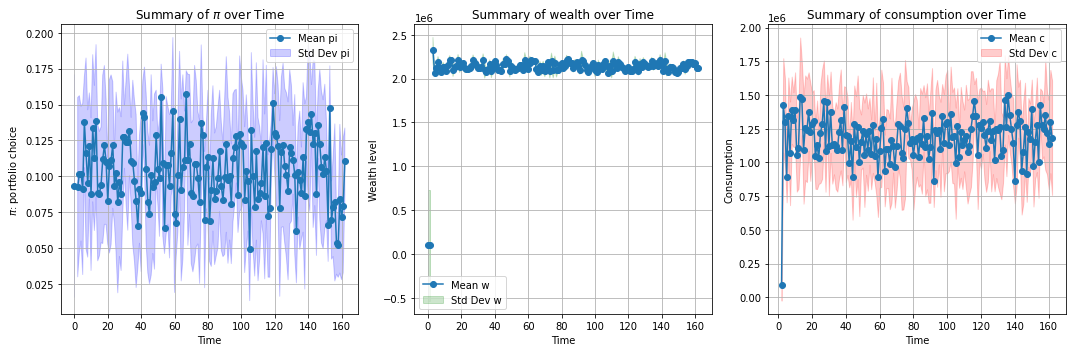

In [30]:

# Function to format the y-axis to thousands
def thousands(x, pos):
    return '%1.0fB' % (x * 1e-9)

formatter = FuncFormatter(thousands)

# Calculate the summary statistics for pi, w, and c in GQ_data
pi_summary = filtered_GQ_data.groupby('time')['pi_GQ'].agg(['mean', 'std'])
w_summary = filtered_GQ_data.groupby('time')['w_GQ'].agg(['mean', 'std'])
c_summary = filtered_GQ_data.groupby('time')['c_GQ'].agg(['mean', 'std'])

# Calculate the summary statistics for pi, w, and c in GQ_data
pi_y_summary = filtered_GQ_data.groupby('year')['pi_GQ'].agg(['mean', 'std'])
w_y_summary = filtered_GQ_data.groupby('year')['w_GQ'].agg(['mean', 'std'])
c_y_summary = filtered_GQ_data.groupby('year')['c_GQ'].agg(['mean', 'std'])

# Plot the summaries
plt.figure(figsize=(15, 5))

# Plot pi summary
plt.subplot(1, 3, 1)
plt.plot(pi_summary.index, pi_summary['mean'], marker='o', label='Mean pi')
plt.fill_between(pi_summary.index, pi_summary['mean'] - pi_summary['std'], pi_summary['mean'] + pi_summary['std'], color='b', alpha=0.2, label='Std Dev pi')
plt.xlabel('Time')
plt.ylabel('$\pi$: portfolio choice')
plt.title('Summary of $\pi$ over Time')
plt.legend()
plt.grid(True)

# Plot w summary
plt.subplot(1, 3, 2)
plt.plot(w_summary.index, w_summary['mean'], marker='o', label='Mean w')
plt.fill_between(w_summary.index, w_summary['mean'] - w_summary['std'], w_summary['mean'] + w_summary['std'], color='g', alpha=0.2, label='Std Dev w')
plt.xlabel('Time')
plt.ylabel('Wealth level')
plt.title('Summary of wealth over Time')
plt.legend()
plt.grid(True)
#plt.gca().yaxis.set_major_formatter(formatter)  # Apply the formatter to the y-axis

# Plot C summary
plt.subplot(1, 3, 3)
plt.plot(c_summary.index, c_summary['mean'], marker='o', label='Mean c')
plt.fill_between(c_summary.index, c_summary['mean'] - c_summary['std'], c_summary['mean'] + c_summary['std'], color='r', alpha=0.2, label='Std Dev c')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.title('Summary of consumption over Time')
plt.legend()
plt.grid(True)
#plt.gca().yaxis.set_major_formatter(formatter)  # Apply the formatter to the y-axis

plt.tight_layout()
plt.show()

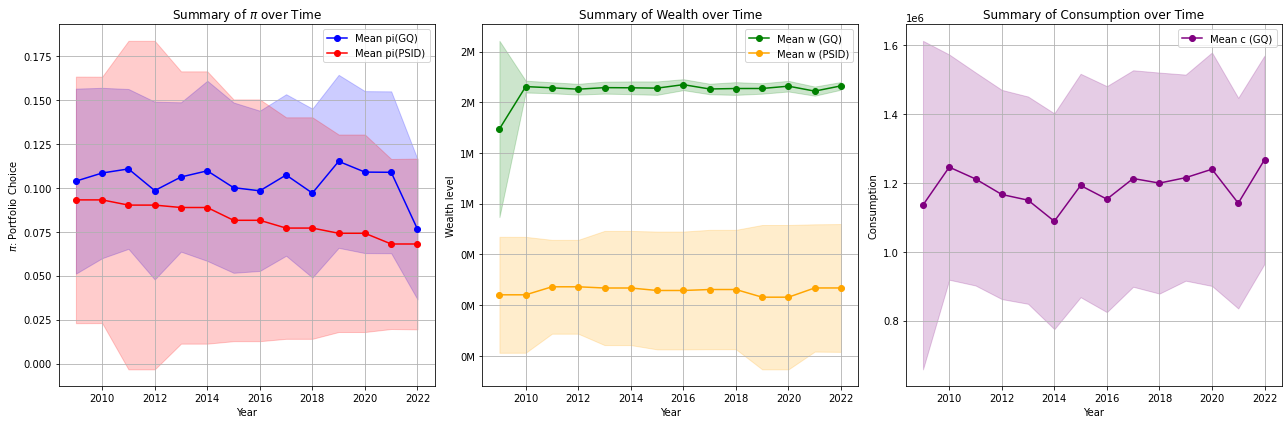

In [31]:

# Calculate the summary statistics for pi, w, and c in GQ_data
pi_y_summary = filtered_GQ_data.groupby('year')['pi_GQ'].agg(['mean', 'std'])
w_y_summary = filtered_GQ_data.groupby('year')['w_GQ'].agg(['mean', 'std'])
c_y_summary = filtered_GQ_data.groupby('year')['c_GQ'].agg(['mean', 'std'])

pi_PSID_y_summary = filtered_GQ_data.groupby('year')['pi_PSID'].agg(['mean', 'std'])
w_PSID_y_summary = filtered_GQ_data.groupby('year')['w_PSID'].agg(['mean', 'std'])

# Formatter for large numbers on the y-axis
formatter = FuncFormatter(lambda x, pos: f'{int(x/1e6)}M')

# Plot the summaries
plt.figure(figsize=(18, 6))

# Plot pi summary
plt.subplot(1, 3, 1)
plt.plot(pi_y_summary.index, pi_y_summary['mean'], marker='o', label='Mean pi(GQ)', color='blue')
plt.fill_between(pi_y_summary.index, pi_y_summary['mean'] - pi_y_summary['std'], pi_y_summary['mean'] + pi_y_summary['std'], color='blue', alpha=0.2)
plt.plot(pi_PSID_y_summary.index, pi_PSID_y_summary['mean'], marker='o', label='Mean pi(PSID)', color='red')
plt.fill_between(pi_PSID_y_summary.index, pi_PSID_y_summary['mean'] - pi_PSID_y_summary['std'], pi_PSID_y_summary['mean'] + pi_PSID_y_summary['std'], color='red', alpha=0.2)
plt.xlabel('Year')
plt.ylabel('$\\pi$: Portfolio Choice')
plt.title('Summary of $\\pi$ over Time')
plt.legend()
plt.grid(True)

# Plot w summary
plt.subplot(1, 3, 2)
plt.plot(w_y_summary.index, w_y_summary['mean'], marker='o', label='Mean w (GQ)', color='green')
plt.fill_between(w_y_summary.index, w_y_summary['mean'] - w_y_summary['std'], w_y_summary['mean'] + w_y_summary['std'], color='green', alpha=0.2)
plt.plot(w_PSID_y_summary.index, w_PSID_y_summary['mean'], marker='o', label='Mean w (PSID)', color='orange')
plt.fill_between(w_PSID_y_summary.index, w_PSID_y_summary['mean'] - w_PSID_y_summary['std'], w_PSID_y_summary['mean'] + w_PSID_y_summary['std'], color='orange', alpha=0.2)
plt.xlabel('Year')
plt.ylabel('Wealth level')
plt.title('Summary of Wealth over Time')
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(formatter)

# Plot c summary
plt.subplot(1, 3, 3)
plt.plot(c_y_summary.index, c_y_summary['mean'], marker='o', label='Mean c (GQ)', color='purple')
plt.fill_between(c_y_summary.index, c_y_summary['mean'] - c_y_summary['std'], c_y_summary['mean'] + c_y_summary['std'], color='purple', alpha=0.2)

plt.xlabel('Year')
plt.ylabel('Consumption')
plt.title('Summary of Consumption over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


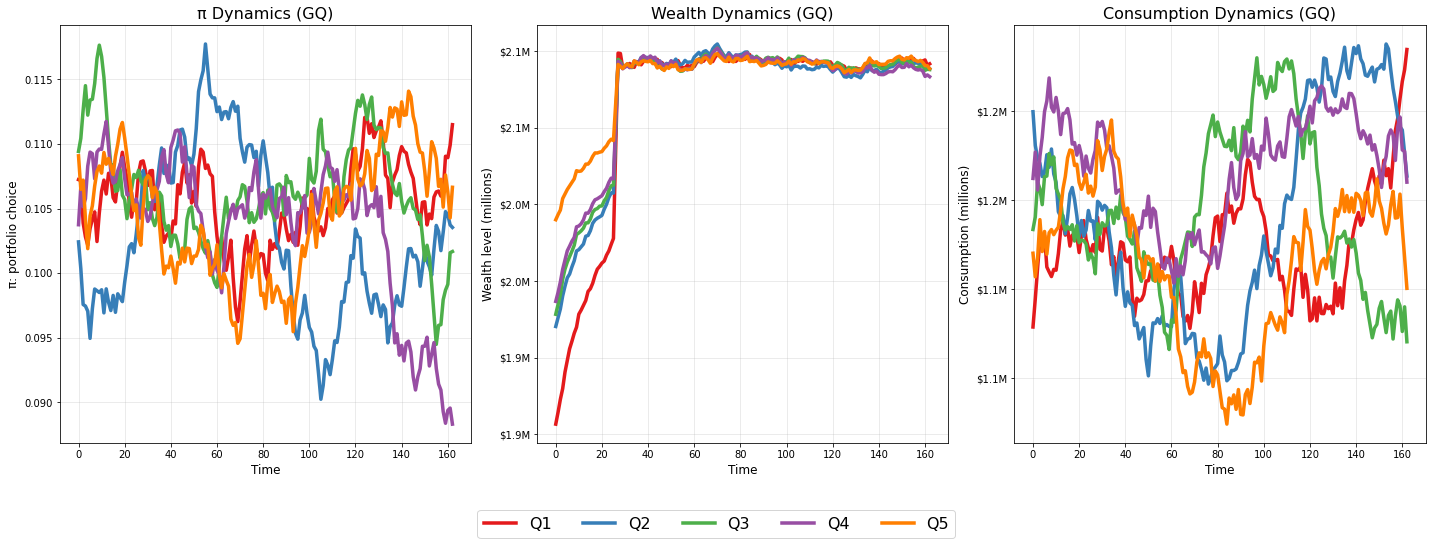

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Assuming GQ_data is your DataFrame
# If not, you'll need to load your data here

# Function to format the y-axis to billions
def millions(x, pos):
    return f'${x*1e-6:.1f}M'

# Define color palette (approximation of R's RColorBrewer "Set1")
color_palette = {
    1: '#E41A1C',  # red
    2: '#377EB8',  # blue
    3: '#4DAF4A',  # green
    4: '#984EA3',  # purple
    5: '#FF7F00'   # orange
}

# Create the figure and axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Define line thickness
line_thickness = 3.5  # Increased line thickness

# Plot for each ID
for id in range(1, 6):  # IDs 1 through 5
    id_data = filtered_GQ_data[filtered_GQ_data['id'] == id].sort_values('time')
    
    # Apply rolling average with window=50
    id_data['pi_smooth'] = id_data['pi_GQ'].rolling(window=50, center=True, min_periods=1).mean()
    id_data['w_smooth'] = id_data['w_GQ'].rolling(window=50, center=True, min_periods=1).mean()
    id_data['c_smooth'] = id_data['c_GQ'].rolling(window=50, center=True, min_periods=1).mean()
    
    color = color_palette[id]
    
    # Plot smoothed pi with thicker lines
    ax1.plot(id_data['time'], id_data['pi_smooth'], color=color, label=f'Q{id}', linewidth=line_thickness)
    
    # Plot smoothed wealth with thicker lines
    ax2.plot(id_data['time'], id_data['w_smooth'], color=color, label=f'Q{id}', linewidth=line_thickness)
    
    # Plot smoothed consumption with thicker lines
    ax3.plot(id_data['time'], id_data['c_smooth'], color=color, label=f'Q{id}', linewidth=line_thickness)

# Customize pi plot
ax1.set_title('π Dynamics (GQ)', fontsize=16)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('π: portfolio choice', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Customize wealth plot
ax2.set_title('Wealth Dynamics (GQ)', fontsize=16)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Wealth level (millions)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(FuncFormatter(millions))
ax2.tick_params(axis='both', which='major', labelsize=10)

# Customize consumption plot
ax3.set_title('Consumption Dynamics (GQ)', fontsize=16)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('Consumption (millions)', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.yaxis.set_major_formatter(FuncFormatter(millions))
ax3.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to make room for the legend
plt.tight_layout()

# Create a single legend for all subplots at the bottom
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.1), fontsize=16)

# Adjust the figure size to accommodate the legend
fig.set_size_inches(20, 7)  # Increased height to make room for legend

plt.show()

# If you want to save the figure
# plt.savefig('smoothed_time_series_graphs.png', dpi=300, bbox_inches='tight')

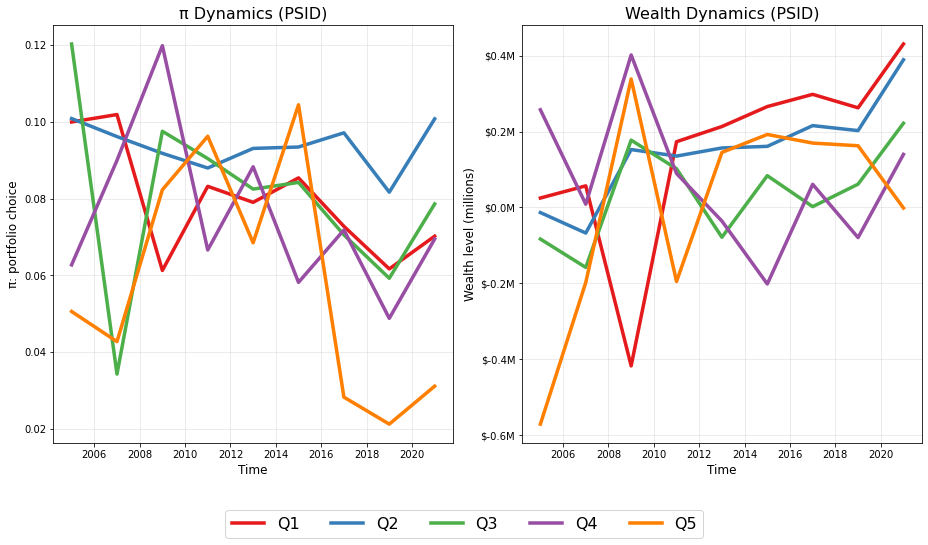

In [33]:

# Function to format the y-axis to millions
def millions(x, pos):
    return f'${x*1e-6:.1f}M'

# Define color palette
color_palette = {
    1: '#E41A1C',  # red
    2: '#377EB8',  # blue
    3: '#4DAF4A',  # green
    4: '#984EA3',  # purple
    5: '#FF7F00'   # orange
}

# Create the figure and axes for two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

# Define line thickness
line_thickness = 3.5  # Increased line thickness

# Plot for each ID
for id in range(1, 6):  # IDs 1 through 5
    id_data = G_data[G_data['id'] == id].sort_values('time')
    
    # Apply rolling average with window=50
    id_data['pi_smooth'] = id_data['pi'].rolling(window=1, center=True, min_periods=1).mean()
    id_data['w_smooth'] = id_data['w'].rolling(window=1, center=True, min_periods=1).mean()
    
    color = color_palette[id]
    
    # Plot smoothed pi_PSID with thicker lines
    ax1.plot(id_data['time'], id_data['pi_smooth'], color=color, label=f'Q{id}', linewidth=line_thickness)
    
    # Plot smoothed wealth_PSID with thicker lines
    ax2.plot(id_data['time'], id_data['w_smooth'], color=color, label=f'Q{id}', linewidth=line_thickness)

# Customize pi_PSID plot
ax1.set_title('π Dynamics (PSID)', fontsize=16)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('π: portfolio choice', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Customize wealth_PSID plot
ax2.set_title('Wealth Dynamics (PSID)', fontsize=16)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Wealth level (millions)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(FuncFormatter(millions))
ax2.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to make room for the legend
plt.tight_layout()

# Create a single legend for all subplots at the bottom
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.1), fontsize=16)

# Adjust the figure size to accommodate the legend
fig.set_size_inches(13, 7)  # Increased height to make room for legend

plt.show()

# If you want to save the figure
# plt.savefig('smoothed_pi_w_PSID_graphs.png', dpi=300, bbox_inches='tight')


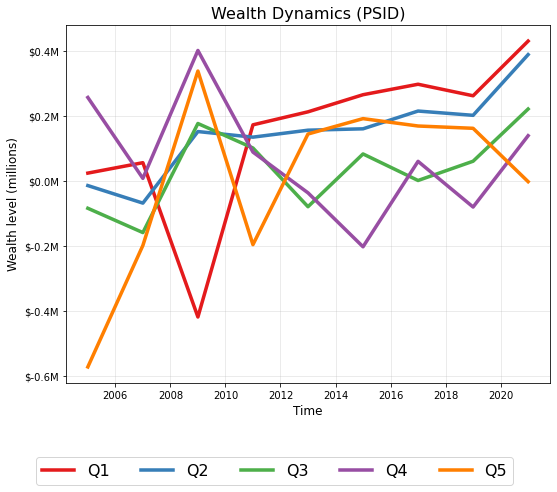

In [53]:
# Function to format the y-axis to millions
def millions(x, pos):
    return f'${x*1e-6:.1f}M'

# Define color palette
color_palette = {
    1: '#E41A1C',  # red
    2: '#377EB8',  # blue
    3: '#4DAF4A',  # green
    4: '#984EA3',  # purple
    5: '#FF7F00'   # orange
}

# Create the figure and axis for the wealth dynamics plot
fig, ax2 = plt.subplots(figsize=(7, 6))  # Adjust figure size as needed

# Define line thickness
line_thickness = 3.5  # Increased line thickness

# Plot for each ID
for id in range(1, 6):  # IDs 1 through 5
    id_data = G_data[G_data['id'] == id].sort_values('time')
    
    # Apply rolling average with window=50
    id_data['w_smooth'] = id_data['w'].rolling(window=1, center=True, min_periods=1).mean()
    
    color = color_palette[id]
    
    # Plot smoothed wealth_PSID with thicker lines
    ax2.plot(id_data['time'], id_data['w_smooth'], color=color, label=f'Q{id}', linewidth=line_thickness)

# Customize wealth_PSID plot
ax2.set_title('Wealth Dynamics (PSID)', fontsize=16)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('Wealth level (millions)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(FuncFormatter(millions))
ax2.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout to make room for the legend
plt.tight_layout()

# Create a single legend at the bottom
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.15), fontsize=16)

# Adjust the figure size to accommodate the legend
fig.set_size_inches(8, 6)  # Adjust as needed to improve layout

plt.show()

# If you want to save the figure
# plt.savefig('smoothed_wealth_PSID_graph.png', dpi=300, bbox_inches='tight')


In [34]:
# Calculate the ratio of c to w for both GQ and PSID
filtered_GQ_data['c_over_w_GQ'] = filtered_GQ_data['c_GQ'] / filtered_GQ_data['w_GQ']

# Smooth the data for better display
pi_summary = filtered_GQ_data.groupby('time')['pi_GQ'].describe().rolling(window=5).mean()
pi_H_summary = filtered_GQ_data.groupby('time')['pi_PSID'].describe().rolling(window=5).mean()
w_summary = filtered_GQ_data.groupby('time')['w_GQ'].describe().rolling(window=5).mean()
w_H_summary = filtered_GQ_data.groupby('time')['w_PSID'].describe().rolling(window=5).mean() # Assuming S_1_MS is available
y_summary = filtered_GQ_data.groupby('time')['y_GQ'].describe().rolling(window=5).mean() # Assuming S_y is available
y_H_summary = filtered_GQ_data.groupby('time')['y_PSID'].describe().rolling(window=5).mean() # Assuming S_y_MS is available
c_summary = filtered_GQ_data.groupby('time')['c_GQ'].describe().rolling(window=5).mean()

# Group by time and calculate descriptive statistics for the ratios
c_r_summary = filtered_GQ_data.groupby('time')['c_over_w_GQ'].describe().rolling(window=5).mean()


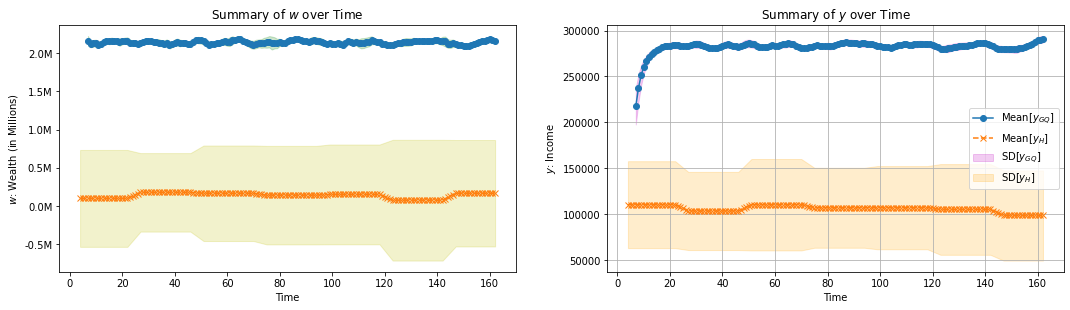

In [35]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Function to convert y-axis labels to 'millions'
def millions(x, pos):
    return f'{x * 1e-6:.1f}M'  # Convert to millions and add 'M' suffix

# Create a figure with multiple subplots to visualize each variable over time
plt.figure(figsize=(18, 10))  # Adjust the figure size for better display

# Plot for wealth (w) over time
plt.subplot(2, 2, 1)
plt.plot(w_summary.index, w_summary['mean'], marker='o', label='Mean[$w_{GQ}$]')
plt.fill_between(w_summary.index, w_summary['mean'] - w_summary['std'], w_summary['mean'] + w_summary['std'], color='g', alpha=0.2, label='SD[$w_{GQ}$]')
plt.plot(w_H_summary.index, w_H_summary['mean'], marker='x', linestyle='--', label='Mean[$w_{H}$]')
plt.fill_between(w_H_summary.index, w_H_summary['mean'] - w_H_summary['std'], w_H_summary['mean'] + w_H_summary['std'], color='y', alpha=0.2, label='SD[$w_{H}$]')
plt.xlabel('Time')
plt.ylabel('$w$: Wealth (in Millions)')
plt.title('Summary of $w$ over Time')

# Apply the formatter to the y-axis of the first subplot
ax1 = plt.gca()  # Get current axis for the first plot
ax1.yaxis.set_major_formatter(FuncFormatter(millions))

# Plot for income (y) over time (without formatting in millions)
plt.subplot(2, 2, 2)
plt.plot(y_summary.index, y_summary['mean'], marker='o', label='Mean[$y_{GQ}$]')
plt.fill_between(y_summary.index, y_summary['mean'] - y_summary['std'], y_summary['mean'] + y_summary['std'], color='m', alpha=0.2, label='SD[$y_{GQ}$]')
plt.plot(y_H_summary.index, y_H_summary['mean'], marker='x', linestyle='--', label='Mean[$y_{H}$]')
plt.fill_between(y_H_summary.index, y_H_summary['mean'] - y_H_summary['std'], y_H_summary['mean'] + y_H_summary['std'], color='orange', alpha=0.2, label='SD[$y_{H}$]')
plt.xlabel('Time')
plt.ylabel('$y$: Income')
plt.title('Summary of $y$ over Time')
plt.legend()
plt.grid(True)

plt.show()


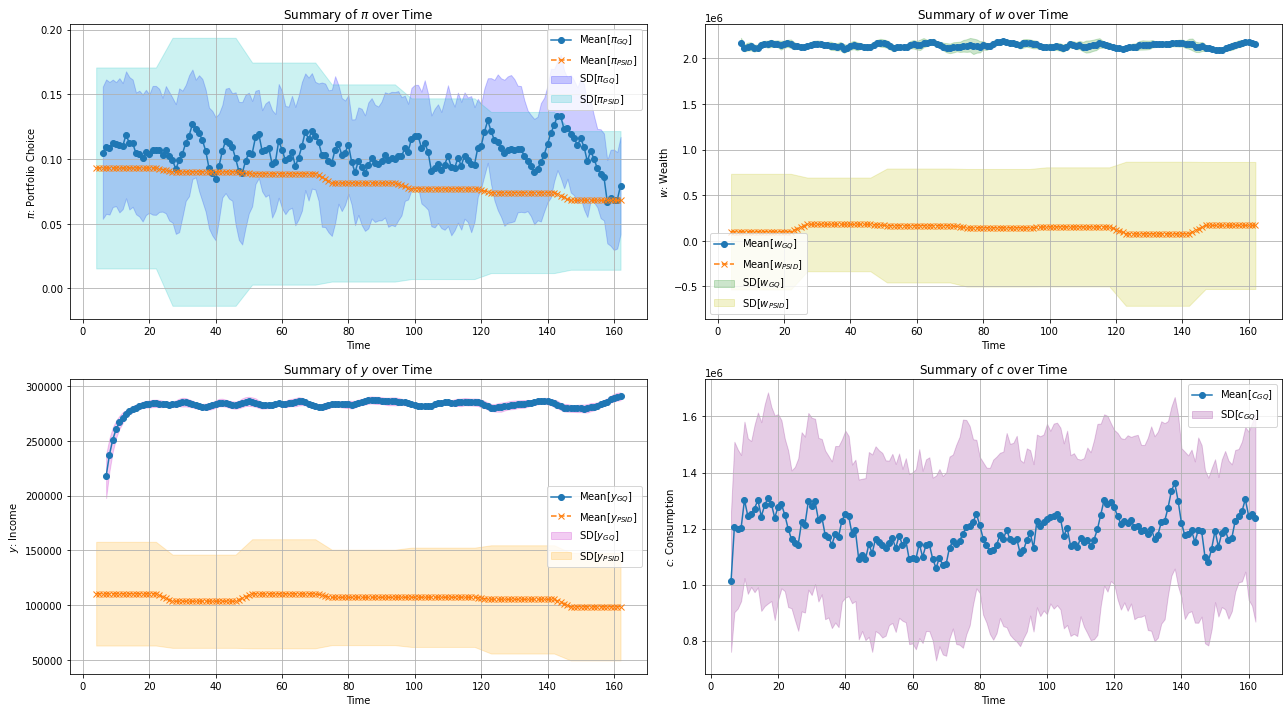

In [36]:
import matplotlib.pyplot as plt

# Create a figure with multiple subplots to visualize each variable over time
plt.figure(figsize=(18, 10))  # Adjust the figure size for better display

# Plot for pi over time
plt.subplot(2, 2, 1)
plt.plot(pi_summary.index, pi_summary['mean'], marker='o', label='Mean[$\\pi_{GQ}$]')
plt.fill_between(pi_summary.index, pi_summary['mean'] - pi_summary['std'], pi_summary['mean'] + pi_summary['std'], color='b', alpha=0.2, label='SD[$\\pi_{GQ}$]')
plt.plot(pi_H_summary.index, pi_H_summary['mean'], marker='x', linestyle='--', label='Mean[$\\pi_{PSID}$]')
plt.fill_between(pi_H_summary.index, pi_H_summary['mean'] - pi_H_summary['std'], pi_H_summary['mean'] + pi_H_summary['std'], color='c', alpha=0.2, label='SD[$\\pi_{PSID}$]')
plt.xlabel('Time')
plt.ylabel('$\\pi$: Portfolio Choice')
plt.title('Summary of $\\pi$ over Time')
plt.legend()
plt.grid(True)

# Plot for wealth (w) over time
plt.subplot(2, 2, 2)
plt.plot(w_summary.index, w_summary['mean'], marker='o', label='Mean[$w_{GQ}$]')
plt.fill_between(w_summary.index, w_summary['mean'] - w_summary['std'], w_summary['mean'] + w_summary['std'], color='g', alpha=0.2, label='SD[$w_{GQ}$]')
plt.plot(w_H_summary.index, w_H_summary['mean'], marker='x', linestyle='--', label='Mean[$w_{PSID}$]')
plt.fill_between(w_H_summary.index, w_H_summary['mean'] - w_H_summary['std'], w_H_summary['mean'] + w_H_summary['std'], color='y', alpha=0.2, label='SD[$w_{PSID}$]')
plt.xlabel('Time')
plt.ylabel('$w$: Wealth')
plt.title('Summary of $w$ over Time')
plt.legend()
plt.grid(True)

# Plot for income (y) over time
plt.subplot(2, 2, 3)
plt.plot(y_summary.index, y_summary['mean'], marker='o', label='Mean[$y_{GQ}$]')
plt.fill_between(y_summary.index, y_summary['mean'] - y_summary['std'], y_summary['mean'] + y_summary['std'], color='m', alpha=0.2, label='SD[$y_{GQ}$]')
plt.plot(y_H_summary.index, y_H_summary['mean'], marker='x', linestyle='--', label='Mean[$y_{PSID}$]')
plt.fill_between(y_H_summary.index, y_H_summary['mean'] - y_H_summary['std'], y_H_summary['mean'] + y_H_summary['std'], color='orange', alpha=0.2, label='SD[$y_{PSID}$]')
plt.xlabel('Time')
plt.ylabel('$y$: Income')
plt.title('Summary of $y$ over Time')
plt.legend()
plt.grid(True)

# Plot for consumption (c) over time
plt.subplot(2, 2, 4)
plt.plot(c_summary.index, c_summary['mean'], marker='o', label='Mean[$c_{GQ}$]')
plt.fill_between(c_summary.index, c_summary['mean'] - c_summary['std'], c_summary['mean'] + c_summary['std'], color='purple', alpha=0.2, label='SD[$c_{GQ}$]')
plt.xlabel('Time')
plt.ylabel('$c$: Consumption')
plt.title('Summary of $c$ over Time')
#plt.ylim(-500, 10000)
plt.legend()
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Policy Functions

In [37]:
filtered_GQ_data.head()

,id,time,pi,pi_lag,L_s,L_s_lag,r_s,r_f,y,w,...,Q_0,predicted_pi,interaction_predicted_pi,interaction_pi,pi_GQ,w_GQ,y_GQ,c_GQ,year,c_over_w_GQ
0,1,0,0.014483,0.149293,1282.618500,865.575500,0.481810,0.146757,66405.222472,-8.476466e+05,...,62415.473951,0.151302,1965.526015,1372.561278,0.014483,-8.476466e+05,66405.222472,NaN,2009,NaN
1,1,1,NaN,0.149293,1321.117888,1282.618500,0.030016,0.126786,66405.222472,-8.476466e+05,...,62415.473951,0.147938,1935.424289,1382.267092,NaN,-8.476466e+05,66405.222472,NaN,2009,NaN
2,1,2,0.154141,0.149293,1304.486514,1321.117888,-0.012589,0.094826,NaN,NaN,...,62415.473951,0.149371,1947.528889,1377.567707,0.154141,NaN,NaN,1.000000e-08,2009,NaN
3,1,3,0.155758,0.149293,1331.505011,1304.486514,0.020712,0.055306,132136.779256,2.569163e+06,...,62415.473951,0.146293,1909.192911,1378.870281,0.155758,2.569163e+06,132136.779256,1.834745e+06,2009,0.714141
4,1,4,0.126667,0.149293,1338.310465,1331.505011,0.005111,0.036818,175139.432559,2.060668e+06,...,62415.473951,0.146997,1918.866749,1379.218378,0.126667,2.060668e+06,175139.432559,1.523645e+06,2009,0.739394


In [38]:


filtered_GQ_data['c_r_GQ'] = filtered_GQ_data['c_GQ'] / filtered_GQ_data['w_GQ']

# Step 2: Group by the real wealth and income values and compute the mean of c_ratio_GQ
c_GQ_by_w = filtered_GQ_data.groupby('w_GQ')['c_r_GQ'].mean().sort_index()
c_GQ_by_y = filtered_GQ_data.groupby('y_GQ')['c_r_GQ'].mean().sort_index()

# Set the window size for smoothing
window_size = 100

# Smooth the grouped data using a rolling mean
smoothed_c_GQ_by_w = c_GQ_by_w.rolling(window=window_size, min_periods=1).mean()
smoothed_c_GQ_by_y = c_GQ_by_y.rolling(window=window_size, min_periods=1).mean()

# Convert the real wealth and income values to millions/thousands for the x-axis
w_millions = smoothed_c_GQ_by_w.index / 1e6
y_thousands = smoothed_c_GQ_by_y.index / 1e3


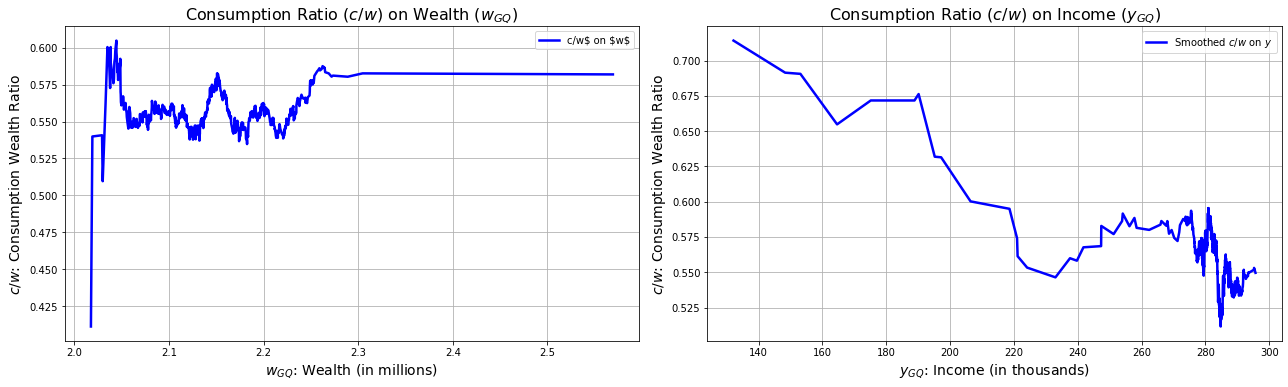

In [40]:
# Create the plot
plt.figure(figsize=(18, 10))

# Create the first plot for smoothed_c_GQ_by_y on y_GQ
plt.subplot(2, 2, 1)
plt.plot(w_millions, smoothed_c_GQ_by_w, label='c/w$ on $w$', color='blue', linewidth=2.5)
plt.xlabel('$w_{GQ}$: Wealth (in millions)', fontsize=14)
plt.ylabel('$c/w$: Consumption Wealth Ratio', fontsize=14)
plt.title('Consumption Ratio ($c/w$) on Wealth ($w_{GQ}$)', fontsize=16)
plt.legend()
plt.grid(True)


# Create the second plot for smoothed_c_GQ_by_w on w_GQ
plt.subplot(2, 2, 2)
plt.plot(y_thousands, smoothed_c_GQ_by_y, label='Smoothed $c/w$ on $y$', color='blue', linewidth=2.5)
plt.xlabel('$y_{GQ}$: Income (in thousands)', fontsize=14)
plt.ylabel('$c/w$: Consumption Wealth Ratio', fontsize=14)
plt.title('Consumption Ratio ($c/w$) on Income ($y_{GQ}$)', fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:

# Group by y and calculate the mean for 'pi_GQ' and 'pi_PSID'
pi_GQ_by_y = filtered_GQ_data.groupby('y')['pi_GQ'].mean()
pi_H_by_y = filtered_GQ_data.groupby('y')['pi_PSID'].mean()

# Set the window size for smoothing
window_size = 100

# Smooth the lines using a rolling mean
smoothed_pi_GQ_by_y = pi_GQ_by_y.rolling(window=window_size, min_periods=1).mean()
smoothed_pi_H_by_y = pi_H_by_y.rolling(window=window_size, min_periods=1).mean()

# Determine the wider range of y values for both datasets
y_min = min(pi_GQ_by_y.index.min(), pi_H_by_y.index.min())
y_max = max(pi_GQ_by_y.index.max(), pi_H_by_y.index.max())

# Create a common income range to plot both on the same scale
common_y = np.linspace(y_min, y_max, 100)

# Interpolate pi_GQ and pi_PSID over the common income range
pi_GQ_interp = np.interp(common_y, smoothed_pi_GQ_by_y.index, smoothed_pi_GQ_by_y)
pi_H_interp = np.interp(common_y, smoothed_pi_H_by_y.index, smoothed_pi_H_by_y)

# Step 2: Group by the original wealth values and compute the mean of pi_PSID and pi_GQ
pi_H_by_w = filtered_GQ_data.groupby('w_PSID')['pi_PSID'].mean()
pi_GQ_by_w = filtered_GQ_data.groupby('w_GQ')['pi_GQ'].mean()

# Create a common w-axis that spans the range of both original wealth values
common_w = np.linspace(min(pi_H_by_w.index.min(), pi_GQ_by_w.index.min()),
                       max(pi_H_by_w.index.max(), pi_GQ_by_w.index.max()), 500)

# Convert the real wealth values to thousands for clearer plotting
common_w_in_thousands = common_w / 1e3
common_w_in_millions = common_w / 1e6

common_y_in_thousands = common_y / 1e3

# Interpolate the pi values on the common wealth axis to ensure smooth plotting
interpolated_pi_H = np.interp(common_w, pi_H_by_w.index, pi_H_by_w)
interpolated_pi_GQ = np.interp(common_w, pi_GQ_by_w.index, pi_GQ_by_w)

# Smooth the lines using a rolling mean for wealth
smoothed_pi_H = pd.Series(interpolated_pi_H).rolling(window=window_size, min_periods=1).mean()
smoothed_pi_GQ = pd.Series(interpolated_pi_GQ).rolling(window=window_size, min_periods=1).mean()



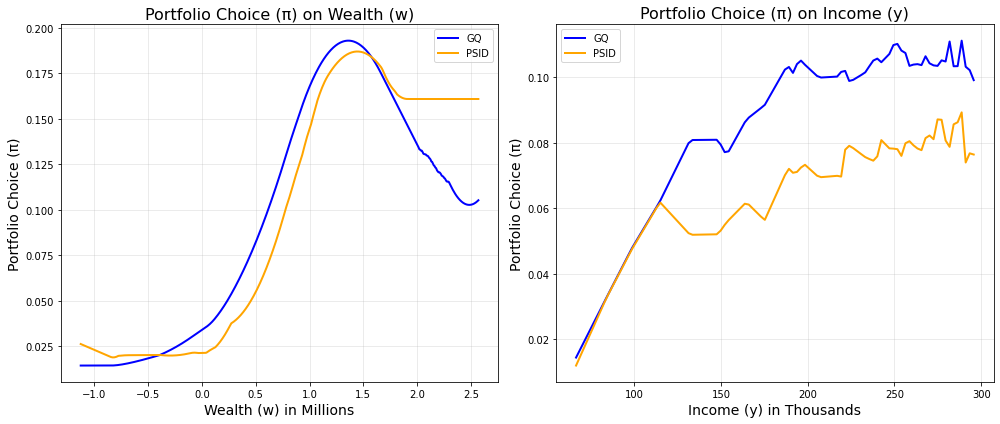

In [42]:
# Plotting the two graphs side by side to contrast pi on wealth (w) and income (y)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot pi on wealth (w)
ax1.plot(common_w_in_millions, smoothed_pi_GQ, label='GQ', color='blue', linewidth=2)
ax1.plot(common_w_in_millions, smoothed_pi_H, label='PSID', color='orange', linewidth=2)
ax1.set_title('Portfolio Choice (π) on Wealth (w)', fontsize=16)
ax1.set_xlabel('Wealth (w) in Millions', fontsize=14)
ax1.set_ylabel('Portfolio Choice (π)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot pi on income (y)
ax2.plot(common_y_in_thousands, pi_GQ_interp, label='GQ', color='blue', linewidth=2)
ax2.plot(common_y_in_thousands, pi_H_interp, label='PSID', color='orange', linewidth=2)
ax2.set_title('Portfolio Choice (π) on Income (y)', fontsize=16)
ax2.set_xlabel('Income (y) in Thousands', fontsize=14)
ax2.set_ylabel('Portfolio Choice (π)', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()



# Adjust layout to make the graphs look cleaner
plt.tight_layout()
plt.show()



### Counterfactual analysis

In [43]:
GQ_data.head()

,id,time,pi,pi_lag,L_s,L_s_lag,r_s,r_f,y,w,...,D_age,Q_0,predicted_pi,interaction_predicted_pi,interaction_pi,pi_GQ,w_GQ,y_GQ,c_GQ,year
0,1,0,0.014483,0.149293,1282.618500,865.575500,0.481810,0.146757,66405.222472,-8.476466e+05,...,47.220225,62415.473951,0.151302,1965.526015,1372.561278,0.014483,-8.476466e+05,66405.222472,NaN,2009
1,1,1,NaN,0.149293,1321.117888,1282.618500,0.030016,0.126786,66405.222472,-8.476466e+05,...,47.220225,62415.473951,0.147938,1935.424289,1382.267092,NaN,-8.476466e+05,66405.222472,NaN,2009
2,1,2,0.154141,0.149293,1304.486514,1321.117888,-0.012589,0.094826,NaN,NaN,...,47.220225,62415.473951,0.149371,1947.528889,1377.567707,0.154141,NaN,NaN,1.000000e-08,2009
3,1,3,0.155758,0.149293,1331.505011,1304.486514,0.020712,0.055306,132136.779256,2.569163e+06,...,47.220225,62415.473951,0.146293,1909.192911,1378.870281,0.155758,2.569163e+06,132136.779256,1.834745e+06,2009
4,1,4,0.126667,0.149293,1338.310465,1331.505011,0.005111,0.036818,175139.432559,2.060668e+06,...,47.220225,62415.473951,0.146997,1918.866749,1379.218378,0.126667,2.060668e+06,175139.432559,1.523645e+06,2009


In [44]:
# Compute the consumption-wealth ratio
filtered_GQ_data['c_r_GQ'] = filtered_GQ_data['c_GQ'] / filtered_GQ_data['w_GQ']

# Compute the growth rate of the consumption-wealth ratio as the percentage change
filtered_GQ_data['g_c_r_GQ'] = (filtered_GQ_data['c_r_GQ'] - filtered_GQ_data['c_r_GQ'].shift(1)) / filtered_GQ_data['c_r_GQ'].shift(1)


NameError: name 'smoothed_g_c_r_GQ_by_y' is not defined

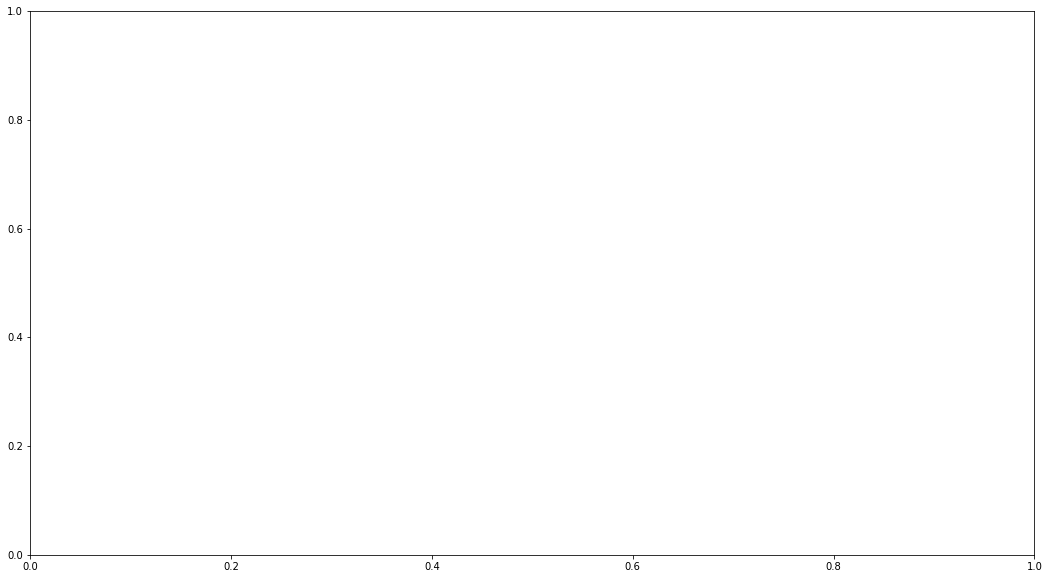

In [45]:
# Plot g_c_r_GQ and pi_GQ on y and L_y with dual y-axes for the aggregate group
plt.figure(figsize=(18, 10))  # Adjust the size of the plot

# Create the primary axis (ax1)
ax1 = plt.gca()

# Plot g_c_r_GQ on ax1 (left y-axis)
ax1.plot(y_thousands, smoothed_g_c_r_GQ_by_y, label='g($c/w$) on $y$', color='tomato', linewidth=3.5)
ax1.set_ylim(-0.05, 0.2)  # Set limits for the growth rate
ax1.set_xlabel('Income (in thousands)', fontsize=20)
ax1.set_ylabel('Growth of $c/w$', fontsize=20, color='tomato')

# Create a secondary y-axis for pi_GQ (ax2)
ax2 = ax1.twinx()

# Plot pi_GQ on ax2 (right y-axis)
ax2.plot(y_thousands, smoothed_pi_GQ_by_y, label='$\\pi_{GQ}$ on $y$', color='blue', linewidth=3.5)
ax2.set_ylim(0, 0.2)  # Set limits for pi_GQ
ax2.set_ylabel('Portfolio Choice ($\\pi$)', fontsize=20, color='blue')

# Title and grid
ax1.set_title('Aggregate: $g(c/w)$ and $\\pi_{GQ}$ on Income ($y$)', fontsize=22)
ax1.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


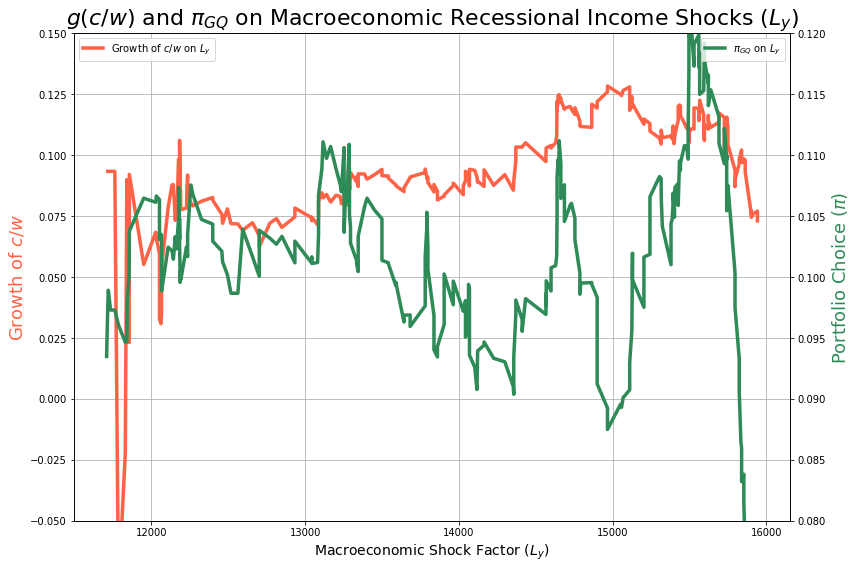

In [46]:
# Group and smooth data for g_c_r_GQ and pi_GQ on L_y
g_c_r_GQ_by_Ly = filtered_GQ_data.groupby('L_y')['g_c_r_GQ'].mean().sort_index()

# Set window size for smoothing
window_size = 100
smoothed_g_c_r_GQ_by_Ly = g_c_r_GQ_by_Ly.rolling(window=window_size, min_periods=1).mean()

# Get L_y values for plotting
L_y = g_c_r_GQ_by_Ly.index

# Interpolate pi_GQ for L_y values and smooth with a window of 20
pi_GQ_by_Ly = filtered_GQ_data.groupby('L_y')['pi_GQ'].mean().sort_index()
pi_GQ_interp = np.interp(L_y, pi_GQ_by_Ly.index, pi_GQ_by_Ly)
smoothed_pi_GQ_by_Ly = pd.Series(pi_GQ_interp).rolling(window=20, min_periods=1).mean()  # Apply rolling window

# Plot with dual y-axes
plt.figure(figsize=(12, 8))  # Adjust figure size for better visibility

# Create primary y-axis (ax1) for g_c_r_GQ
ax1 = plt.gca()

# Plot g_c_r_GQ on ax1 (left y-axis)
ax1.plot(L_y, smoothed_g_c_r_GQ_by_Ly, label='Growth of $c/w$ on $L_y$', color='tomato', linewidth=3.5)
ax1.set_ylim(-0.05, 0.15)  # Set limits for growth rate
ax1.set_xlabel('Macroeconomic Shock Factor ($L_y$)', fontsize=14)
ax1.set_ylabel('Growth of $c/w$', fontsize=18, color='tomato')

# Create secondary y-axis (ax2) for pi_GQ
ax2 = ax1.twinx()

# Plot smoothed pi_GQ on ax2 (right y-axis)
ax2.plot(L_y, smoothed_pi_GQ_by_Ly, label='$\\pi_{GQ}$ on $L_y$', color='seagreen', linewidth=3.5)
ax2.set_ylim(0.08, 0.12)  # Set limits for pi_GQ
ax2.set_ylabel('Portfolio Choice ($\\pi$)', fontsize=18, color='seagreen')

# Title and grid
ax1.set_title('$g(c/w)$ and $\\pi_{GQ}$ on Macroeconomic Recessional Income Shocks ($L_y$)', fontsize=22)
ax1.grid(True)

# Legend for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


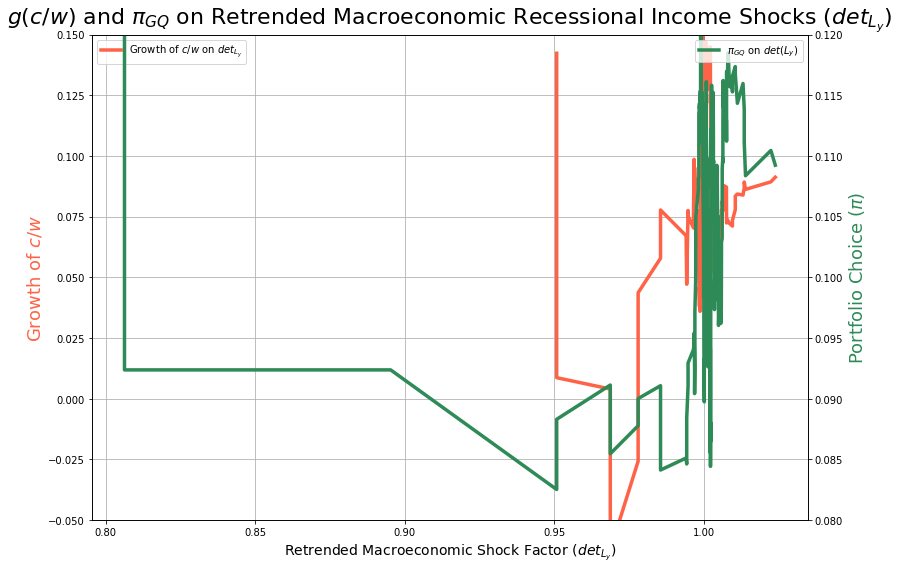

In [49]:
# Calculate det_L_y: L_y retrended by dividing by the rolling mean over the last 12 periods
L_y_rolling_mean = filtered_GQ_data['L_y'].rolling(window=3, min_periods=1).mean()
filtered_GQ_data['det_L_y'] = filtered_GQ_data['L_y'] / L_y_rolling_mean

# Group and smooth data for g_c_r_GQ and pi_GQ on det_L_y
g_c_r_GQ_by_det_Ly = filtered_GQ_data.groupby('det_L_y')['g_c_r_GQ'].mean().sort_index()

# Set window size for smoothing
window_size = 100
smoothed_g_c_r_GQ_by_det_Ly = g_c_r_GQ_by_det_Ly.rolling(window=window_size, min_periods=1).mean()

# Get det_L_y values for plotting
det_L_y = g_c_r_GQ_by_det_Ly.index

# Interpolate pi_GQ for det_L_y values and smooth with a window of 20
pi_GQ_by_det_Ly = filtered_GQ_data.groupby('det_L_y')['pi_GQ'].mean().sort_index()
pi_GQ_interp = np.interp(det_L_y, pi_GQ_by_det_Ly.index, pi_GQ_by_det_Ly)
smoothed_pi_GQ_by_det_Ly = pd.Series(pi_GQ_interp).rolling(window=20, min_periods=1).mean()

# Plot with dual y-axes
plt.figure(figsize=(12, 8))  # Adjust figure size for better visibility

# Create primary y-axis (ax1) for g_c_r_GQ
ax1 = plt.gca()

# Plot g_c_r_GQ on ax1 (left y-axis)
ax1.plot(det_L_y, smoothed_g_c_r_GQ_by_det_Ly, label='Growth of $c/w$ on $det_{L_y}$', color='tomato', linewidth=3.5)
ax1.set_ylim(-0.05, 0.15)  # Set limits for growth rate
ax1.set_xlabel('Retrended Macroeconomic Shock Factor ($det_{L_y}$)', fontsize=14)
ax1.set_ylabel('Growth of $c/w$', fontsize=18, color='tomato')

# Create secondary y-axis (ax2) for pi_GQ
ax2 = ax1.twinx()

# Plot smoothed pi_GQ on ax2 (right y-axis)
ax2.plot(det_L_y, smoothed_pi_GQ_by_det_Ly, label='$\\pi_{GQ}$ on $det(L_y)$', color='seagreen', linewidth=3.5)
ax2.set_ylim(0.08, 0.12)  # Set limits for pi_GQ
ax2.set_ylabel('Portfolio Choice ($\\pi$)', fontsize=18, color='seagreen')

# Title and grid
ax1.set_title('$g(c/w)$ and $\\pi_{GQ}$ on Retrended Macroeconomic Recessional Income Shocks ($det_{L_y}$)', fontsize=22)
ax1.grid(True)

# Legend for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


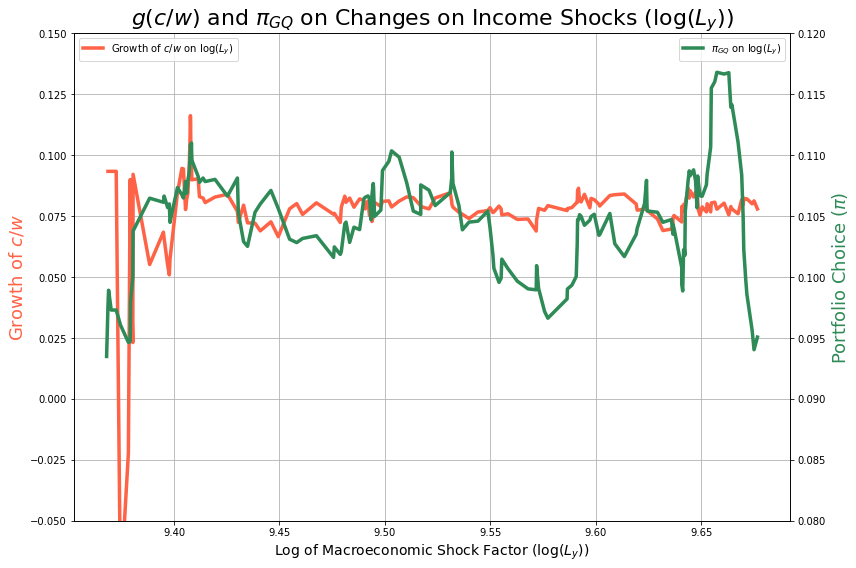

In [51]:
# Calculate log(L_y)
filtered_GQ_data['log_L_y'] = np.log(filtered_GQ_data['L_y'])

# Group and smooth data for g_c_r_GQ and pi_GQ on log(L_y)
g_c_r_GQ_by_log_Ly = filtered_GQ_data.groupby('log_L_y')['g_c_r_GQ'].mean().sort_index()

# Set window size for smoothing
window_size = 100
smoothed_g_c_r_GQ_by_log_Ly = g_c_r_GQ_by_log_Ly.rolling(window=window_size, min_periods=1).mean()

# Get log_L_y values for plotting
log_L_y = g_c_r_GQ_by_log_Ly.index

# Interpolate pi_GQ for log_L_y values and smooth with a window of 20
pi_GQ_by_log_Ly = filtered_GQ_data.groupby('log_L_y')['pi_GQ'].mean().sort_index()
pi_GQ_interp = np.interp(log_L_y, pi_GQ_by_log_Ly.index, pi_GQ_by_log_Ly)
smoothed_pi_GQ_by_log_Ly = pd.Series(pi_GQ_interp).rolling(window=20, min_periods=1).mean()

# Plot with dual y-axes
plt.figure(figsize=(12, 8))  # Adjust figure size for better visibility

# Create primary y-axis (ax1) for g_c_r_GQ
ax1 = plt.gca()

# Plot g_c_r_GQ on ax1 (left y-axis)
ax1.plot(log_L_y, smoothed_g_c_r_GQ_by_log_Ly, label='Growth of $c/w$ on $\\log(L_y)$', color='tomato', linewidth=3.5)
ax1.set_ylim(-0.05, 0.15)  # Set limits for growth rate
ax1.set_xlabel('Log of Macroeconomic Shock Factor ($\\log(L_y)$)', fontsize=14)
ax1.set_ylabel('Growth of $c/w$', fontsize=18, color='tomato')

# Create secondary y-axis (ax2) for pi_GQ
ax2 = ax1.twinx()

# Plot smoothed pi_GQ on ax2 (right y-axis)
ax2.plot(log_L_y, smoothed_pi_GQ_by_log_Ly, label='$\\pi_{GQ}$ on $\\log(L_y)$', color='seagreen', linewidth=3.5)
ax2.set_ylim(0.08, 0.12)  # Set limits for pi_GQ
ax2.set_ylabel('Portfolio Choice ($\\pi$)', fontsize=18, color='seagreen')

# Title and grid
ax1.set_title('$g(c/w)$ and $\\pi_{GQ}$ on Changes on Income Shocks ($\\log(L_y)$)', fontsize=22)
ax1.grid(True)

# Legend for both plots
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


/var/folders/4x/4blksd7x45lcmt849bdjyrf40000gn/T/ipykernel_59956/1778936576.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['g_c_r_GQ'] = (filtered_data['c_r_GQ'] - filtered_data['c_r_GQ'].shift(1)) / filtered_data['c_r_GQ'].shift(1)
/var/folders/4x/4blksd7x45lcmt849bdjyrf40000gn/T/ipykernel_59956/1778936576.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['g_c_r_GQ'] = (filtered_data['c_r_GQ'] - filtered_data['c_r_GQ'].shift(1)) / filtered_data['c_r_GQ'].shift(1)
/var/f

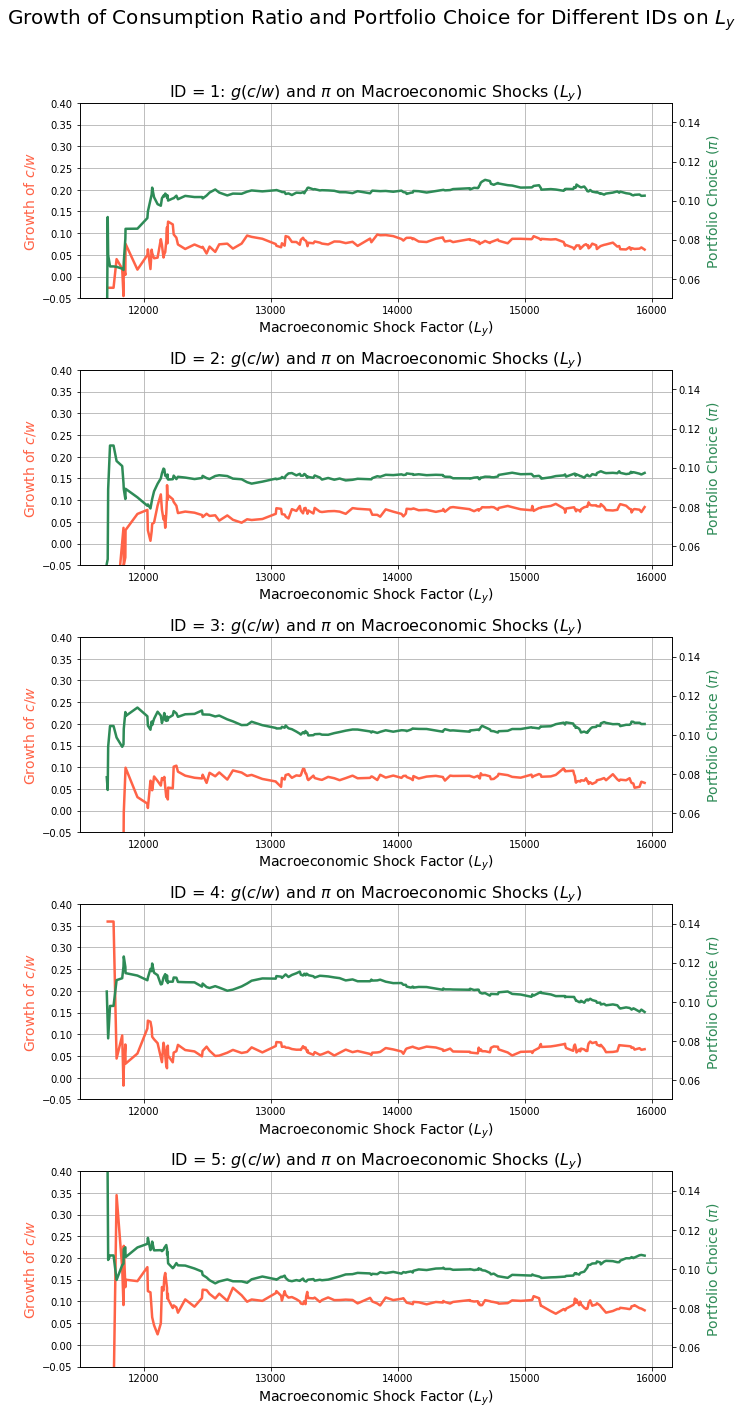

In [171]:
# Set up a figure to plot each id in a separate subplot with dual y-axes on L_y
fig, axes = plt.subplots(5, 1, figsize=(10, 20))  # 5 rows, 1 column (one for each id)
fig.suptitle('Growth of Consumption Ratio and Portfolio Choice for Different IDs on $L_y$', fontsize=20)

# Define the list of ids to loop through
ids_to_plot = [1, 2, 3, 4, 5]

for i, household_id in enumerate(ids_to_plot):
    # Filter the data for the current id
    filtered_data = filtered_GQ_data[filtered_GQ_data['id'] == household_id]

    # Compute g_c_r_GQ for the current id
    filtered_data['g_c_r_GQ'] = (filtered_data['c_r_GQ'] - filtered_data['c_r_GQ'].shift(1)) / filtered_data['c_r_GQ'].shift(1)

    # Group by macroeconomic shock (L_y) for the current id
    g_c_r_GQ_by_Ly = filtered_data.groupby('L_y')['g_c_r_GQ'].mean().sort_index()
    pi_GQ_by_Ly = filtered_data.groupby('L_y')['pi_GQ'].mean().sort_index()

    # Smooth the data
    window_size = 100
    smoothed_g_c_r_GQ_by_Ly = g_c_r_GQ_by_Ly.rolling(window=window_size, min_periods=1).mean()
    smoothed_pi_GQ_by_Ly = pi_GQ_by_Ly.rolling(window=window_size, min_periods=1).mean()

    # Get the L_y values (macroeconomic shocks)
    L_y = smoothed_g_c_r_GQ_by_Ly.index

    # Plot for L_y (one column only)
    ax = axes[i]
    ax2 = ax.twinx()  # Create secondary y-axis

    # Plot g_c_r_GQ on ax (left y-axis)
    ax.plot(L_y, smoothed_g_c_r_GQ_by_Ly, label='g($c/w$) on $L_y$', color='tomato', linewidth=2.5)
    ax.set_ylim(-0.05, 0.4)  # Set limits for growth rate
    ax.set_xlabel('Macroeconomic Shock Factor ($L_y$)', fontsize=14)
    ax.set_ylabel('Growth of $c/w$', fontsize=14, color='tomato')

    # Plot pi_GQ on ax2 (right y-axis)
    ax2.plot(L_y, smoothed_pi_GQ_by_Ly, label='$\\pi_{GQ}$ on $L_y$', color='seagreen', linewidth=2.5)
    ax2.set_ylim(0.05, 0.15)  # Set limits for pi
    ax2.set_ylabel('Portfolio Choice ($\\pi$)', fontsize=14, color='seagreen')

    # Title and grid
    ax.set_title(f'ID = {household_id}: $g(c/w)$ and $\\pi$ on Macroeconomic Shocks ($L_y$)', fontsize=16)
    ax.grid(True)

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to leave space for the main title
plt.show()


/var/folders/4x/4blksd7x45lcmt849bdjyrf40000gn/T/ipykernel_22344/887269387.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['g_c_r_GQ'] = (filtered_data['c_r_GQ'] - filtered_data['c_r_GQ'].shift(1)) / filtered_data['c_r_GQ'].shift(1)
/var/folders/4x/4blksd7x45lcmt849bdjyrf40000gn/T/ipykernel_22344/887269387.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['log_L_y'] = np.log(filtered_data['L_y'])
/var/folders/4x/4blksd7x45lcmt849bdjyrf40000gn/T/ipykernel_22344/887269387.p

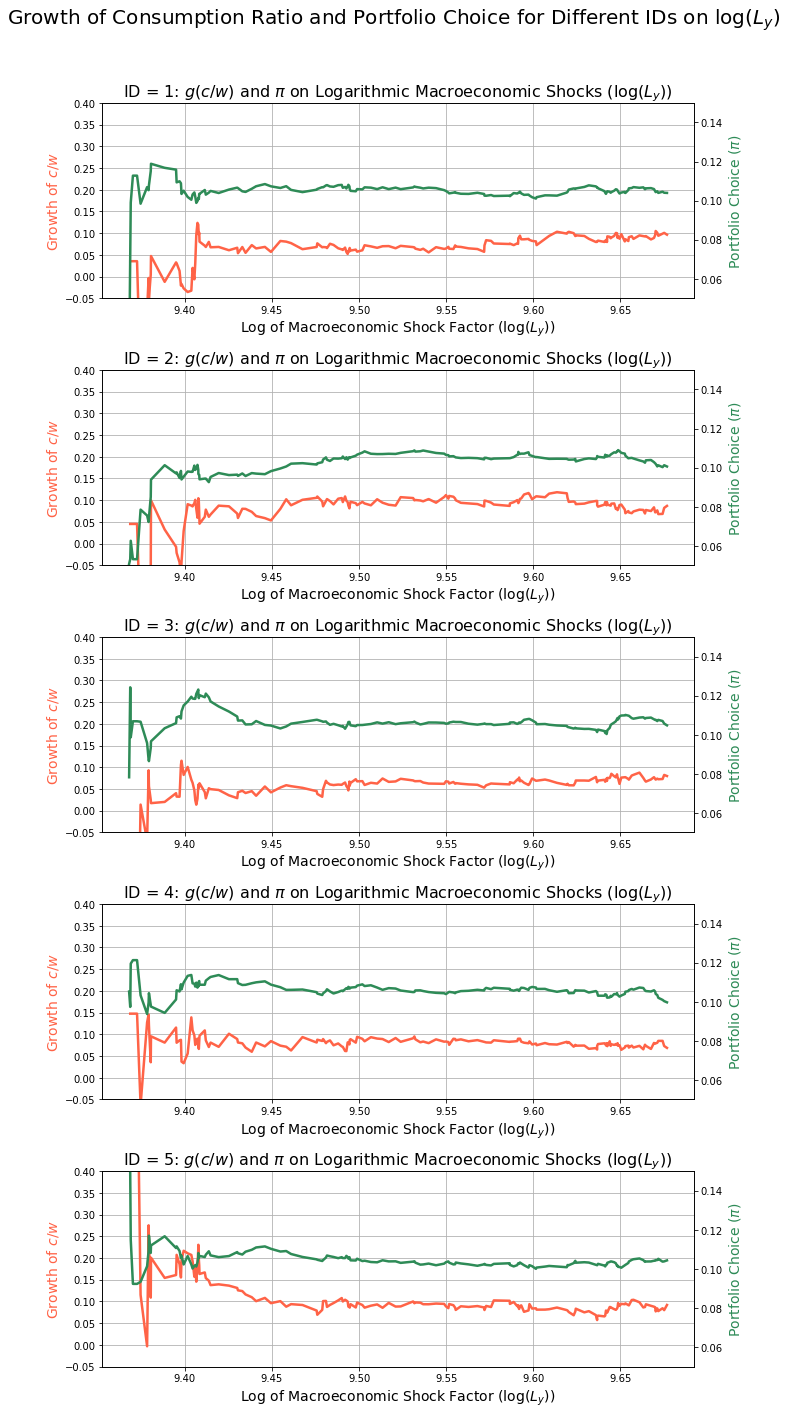

In [52]:
# Set up a figure to plot each id in a separate subplot with dual y-axes on log(L_y)
fig, axes = plt.subplots(5, 1, figsize=(10, 20))  # 5 rows, 1 column (one for each id)
fig.suptitle('Growth of Consumption Ratio and Portfolio Choice for Different IDs on $\\log(L_y)$', fontsize=20)

# Define the list of ids to loop through
ids_to_plot = [1, 2, 3, 4, 5]

for i, household_id in enumerate(ids_to_plot):
    # Filter the data for the current id
    filtered_data = filtered_GQ_data[filtered_GQ_data['id'] == household_id]

    # Compute g_c_r_GQ for the current id
    filtered_data['g_c_r_GQ'] = (filtered_data['c_r_GQ'] - filtered_data['c_r_GQ'].shift(1)) / filtered_data['c_r_GQ'].shift(1)

    # Calculate log(L_y)
    filtered_data['log_L_y'] = np.log(filtered_data['L_y'])

    # Group by log of macroeconomic shock (log_L_y) for the current id
    g_c_r_GQ_by_log_Ly = filtered_data.groupby('log_L_y')['g_c_r_GQ'].mean().sort_index()
    pi_GQ_by_log_Ly = filtered_data.groupby('log_L_y')['pi_GQ'].mean().sort_index()

    # Smooth the data
    window_size = 100
    smoothed_g_c_r_GQ_by_log_Ly = g_c_r_GQ_by_log_Ly.rolling(window=window_size, min_periods=1).mean()
    smoothed_pi_GQ_by_log_Ly = pi_GQ_by_log_Ly.rolling(window=window_size, min_periods=1).mean()

    # Get the log_L_y values (log of macroeconomic shocks)
    log_L_y = smoothed_g_c_r_GQ_by_log_Ly.index

    # Plot for log_L_y (one column only)
    ax = axes[i]
    ax2 = ax.twinx()  # Create secondary y-axis

    # Plot g_c_r_GQ on ax (left y-axis)
    ax.plot(log_L_y, smoothed_g_c_r_GQ_by_log_Ly, label='g($c/w$) on $\\log(L_y)$', color='tomato', linewidth=2.5)
    ax.set_ylim(-0.05, 0.4)  # Set limits for growth rate
    ax.set_xlabel('Log of Macroeconomic Shock Factor ($\\log(L_y)$)', fontsize=14)
    ax.set_ylabel('Growth of $c/w$', fontsize=14, color='tomato')

    # Plot pi_GQ on ax2 (right y-axis)
    ax2.plot(log_L_y, smoothed_pi_GQ_by_log_Ly, label='$\\pi_{GQ}$ on $\\log(L_y)$', color='seagreen', linewidth=2.5)
    ax2.set_ylim(0.05, 0.15)  # Set limits for pi
    ax2.set_ylabel('Portfolio Choice ($\\pi$)', fontsize=14, color='seagreen')

    # Title and grid
    ax.set_title(f'ID = {household_id}: $g(c/w)$ and $\\pi$ on Logarithmic Macroeconomic Shocks ($\\log(L_y)$)', fontsize=16)
    ax.grid(True)

# Adjust layout to avoid overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to leave space for the main title
plt.show()


In [175]:
# Define the list of ids to loop through
ids_to_plot = [1, 2, 3, 4, 5]

for household_id in ids_to_plot:
    # Create a new figure for each household id
    plt.figure(figsize=(10, 6))  # Adjust the figure size for each graph
    
    # Filter the data for the current id
    filtered_data = filtered_GQ_data[filtered_GQ_data['id'] == household_id]

    # Compute g_c_r_GQ for the current id
    filtered_data['g_c_r_GQ'] = (filtered_data['c_r_GQ'] - filtered_data['c_r_GQ'].shift(1)) / filtered_data['c_r_GQ'].shift(1)

    # Group by macroeconomic shock (L_y) for the current id
    g_c_r_GQ_by_Ly = filtered_data.groupby('L_y')['g_c_r_GQ'].mean().sort_index()
    pi_GQ_by_Ly = filtered_data.groupby('L_y')['pi_GQ'].mean().sort_index()

    # Smooth the data
    window_size = 100
    smoothed_g_c_r_GQ_by_Ly = g_c_r_GQ_by_Ly.rolling(window=window_size, min_periods=1).mean()
    smoothed_pi_GQ_by_Ly = pi_GQ_by_Ly.rolling(window=window_size, min_periods=1).mean()

    # Get the L_y values (macroeconomic shocks)
    L_y = smoothed_g_c_r_GQ_by_Ly.index

    # Create primary axis for g_c_r_GQ
    ax = plt.gca()
    ax2 = ax.twinx()  # Create secondary y-axis for pi_GQ

    # Plot g_c_r_GQ on ax (left y-axis)
    ax.plot(L_y, smoothed_g_c_r_GQ_by_Ly, label='g($c/w$) on $L_y$', color='tomato', linewidth=2.5)
    ax.set_ylim(-0.05, 0.4)  # Set limits for growth rate
    ax.set_xlabel('Macroeconomic Shock Factor ($L_y$)', fontsize=14)
    ax.set_ylabel('Growth of $c/w$', fontsize=14, color='tomato')

    # Plot pi_GQ on ax2 (right y-axis)
    ax2.plot(L_y, smoothed_pi_GQ_by_Ly, label='$\\pi_{GQ}$ on $L_y$', color='seagreen', linewidth=2.5)
    ax2.set_ylim(0.05, 0.15)  # Set limits for pi
    ax2.set_ylabel('Portfolio Choice ($\\pi$)', fontsize=14, color='seagreen')

    # Title and grid
    ax.set_title(f'ID = {household_id}: $g(c/w)$ and $\\pi$ on Macroeconomic Shocks ($L_y$)', fontsize=16)
    ax.grid(True)

    # Save the figure
    plt.tight_layout()
    plt.savefig(f'/Users/ivyyang/Dropbox/cloud/Research/Research 2023/GQ/writing/plot_id_{household_id}.png')  # Save each graph as a PNG file with a unique name

    # Close the figure after saving
    plt.close()


/var/folders/4x/4blksd7x45lcmt849bdjyrf40000gn/T/ipykernel_59956/3913789159.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['g_c_r_GQ'] = (filtered_data['c_r_GQ'] - filtered_data['c_r_GQ'].shift(1)) / filtered_data['c_r_GQ'].shift(1)
/var/folders/4x/4blksd7x45lcmt849bdjyrf40000gn/T/ipykernel_59956/3913789159.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['g_c_r_GQ'] = (filtered_data['c_r_GQ'] - filtered_data['c_r_GQ'].shift(1)) / filtered_data['c_r_GQ'].shift(1)
/var/f